In [67]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #if having multiple GPUs in the system 

#%%
#clear warnings and session

import warnings 
warnings.filterwarnings('ignore',category=FutureWarning) 
import tensorflow as tf
from tensorflow.keras import backend as K
K.clear_session()

#%%
#import other libraries

import struct
from tensorflow.keras.preprocessing.image import img_to_array
import statistics
import zlib
import time
import glob
import itertools
from itertools import cycle
from matplotlib import pyplot
import numpy as np
from numpy import sqrt, argmax, genfromtxt
from scipy import interp
from scipy.optimize import minimize
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
from vit_keras import vit, utils, visualize
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Flatten, Concatenate, ZeroPadding2D, GlobalAveragePooling2D, Dense
from sklearn import metrics
from sklearn.utils import compute_class_weight
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.metrics import roc_curve, auc,  precision_recall_curve, average_precision_score, matthews_corrcoef
from sklearn.metrics import f1_score, cohen_kappa_score, precision_score, recall_score, classification_report, log_loss, confusion_matrix, accuracy_score 
from sklearn.utils import class_weight
import matplotlib.patches as mpatches
import seaborn as sns
import tensorflow_addons as tfa

In [2]:
def Generate_CRM_2Class(thisModel, thisImg_path, Threshold):             # generate Class Revlevance Map (CRM)
    try:
        # preprocess input image      
        width, height = thisModel.input.shape[1:3].as_list()
        original_img = cv2.imread(thisImg_path) 
        resized_original_image = cv2.resize(original_img, (width,height))        
    
        input_image = img_to_array(resized_original_image)
        input_image = np.array(input_image, dtype="float") /255.0       
        input_image = input_image.reshape((1,) + input_image.shape)
    
        class_weights = thisModel.layers[-1].get_weights()[0]
    
        get_output = K.function([thisModel.layers[0].input], [thisModel.layers[-3].output, #change this based on the deepest convolutional layer
                                 thisModel.layers[-1].output])
        [conv_outputs, predictions] = get_output([input_image])
        conv_outputs = conv_outputs[ 0, :, :, :]     
        final_output = predictions   
        
        wf0 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])    
        wf1 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])    
    
        for i, w in enumerate(class_weights[:, 0]):     
            wf0 += w * conv_outputs[:, :, i]           
        S0 = np.sum(wf0)           # score at node 0 in the final output layer
        for i, w in enumerate(class_weights[:, 1]):     
            wf1 += w * conv_outputs[:, :, i]             
        S1 = np.sum(wf1)           # score at node 1 in the final output layer
    
        #Calculate incremental MSE
        iMSE0 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        iMSE1 = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    
        row, col = wf0.shape
        for x in range (row):
                for y in range (col):
                        tmp0 = np.array(wf0)
                        tmp0[x,y] = 0.                   # remove activation at the spatial location (x,y)
                        iMSE0[x,y] = (S0 - np.sum(tmp0)) ** 2
    
                        tmp1 = np.array(wf1)
                        tmp1[x,y] = 0.                  
                        iMSE1[x,y] = (S1 - np.sum(tmp1)) ** 2
         
      
        Final_crm = iMSE0 + iMSE1       # consider both positive and negative contribution
    
        Final_crm /= np.max(Final_crm)    # normalize
        resized_Final_crm = cv2.resize(Final_crm, (height, width)) # upscaling to original image size

        The_CRM = np.array(resized_Final_crm)
        The_CRM[np.where(resized_Final_crm < Threshold)] = 0.  # clean-up (remove data below threshold)

        return[resized_original_image, final_output, resized_Final_crm, The_CRM]
    except Exception as e:
        raise Exception('Error from Generate_CRM_2Class(): ' + str(e))

In [69]:
# custom function to find max mode

def find_max_mode(list1):
    list_table = statistics._counts(list1)
    len_table = len(list_table)

    if len_table == 1:
        max_mode = statistics.mode(list1)
    else:
        new_list = []
        for i in range(len_table):
            new_list.append(list_table[i][0])
        max_mode = max(new_list) # use the max value here
    return max_mode

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
def matrix_metrix(real_values,pred_values,beta):
    CM = confusion_matrix(real_values,pred_values)
    TN = CM[0][0]
    FN = CM[1][0] 
    TP = CM[1][1]
    FP = CM[0][1]
    Population = TN+FN+TP+FP
    Kappa = 2 * (TP * TN - FN * FP) / (TP * FN + TP * FP + 2 * TP * TN + FN**2 + FN * TN + FP**2 + FP * TN)
    Accuracy   = round( (TP+TN) / Population,4)
    Precision  = round( TP / (TP+FP),4 )
    Recall     = round( TP / (TP+FN),4 )
    F1         = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
    MCC        = round ( ((TP*TN)-(FP*FN))/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))  ,4)
    mat_met = pd.DataFrame({'Metric':['TP','TN','FP','FN','Accuracy','Precision','Recall','F1','MCC','Kappa'],
                            'Value':[TP,TN,FP,FN,Accuracy,Precision,Recall,F1,MCC,Kappa]})
    return (mat_met)

In [1]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Define the path to your dataset
dataset_dir = "dataset"  # Replace with the actual path

# Define the classes in your dataset
classes = ['no', 'yes']  # Replace with your actual class names

# Define the ratio for splitting (e.g., 80% training, 20% testing)
train_ratio = 0.9

# Create directories for training and testing data
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Make sure the directories don't exist before creating them
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Iterate over each class and split the data
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    
    # Get a list of all files in the class directory
    files = os.listdir(class_path)
    
    # Split the files into training and testing sets
    train_files, test_files = train_test_split(files, train_size=train_ratio, random_state=42)
    
    # Move files to the appropriate directories
    for file in train_files:
        source_path = os.path.join(class_path, file)
        destination_path = os.path.join(train_dir, class_name, file)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.move(source_path, destination_path)

    for file in test_files:
        source_path = os.path.join(class_path, file)
        destination_path = os.path.join(test_dir, class_name, file)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        shutil.move(source_path, destination_path)

print("Data has been successfully split into training and testing sets.")


Data has been successfully split into training and testing sets.


In [28]:
img_width, img_height = 224,224
train_data_dir = "dataset/train"
test_data_dir = "dataset/test"
epochs = 64 
batch_size =16 # vary based on GPU capacity
num_classes = 2 # no-finding, abnormal
input_shape = (img_width, img_height, 3)
model_input = Input(shape=input_shape)
print(model_input) 

#%%
# declare image data generators

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2) 

test_datagen = ImageDataGenerator(
        rescale=1./255) 

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        seed=123,
        batch_size=batch_size,
        shuffle = True,
        class_mode='categorical', 
        subset = 'training')

validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        seed=123,
        batch_size=batch_size, 
        shuffle = False,
        class_mode='categorical', 
        subset = 'validation')

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size, 
        shuffle = False,
        class_mode='categorical')

#identify the number of samples
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
nb_test_samples = len(test_generator.filenames)

#check the class indices
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

# ground truth labels
Y_test=test_generator.classes
print(Y_test.shape)
Y_test1=to_categorical(Y_test, 
                       num_classes=num_classes, 
                       dtype='float32')
print(Y_test1.shape)


KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Found 692 images belonging to 2 classes.
Found 172 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}
(96,)
(96, 2)


In [56]:
vit_model = vit.vit_b16(
        image_size = img_width,        
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        weights="imagenet21k+imagenet2012",
        classes = num_classes)

for layer in vit_model.layers[:-5]:
    layer.trainable = False

vit_model.summary()
out = tf.keras.layers.Flatten()(vit_model.output)
out = tf.keras.layers.Dense(num_classes, 'softmax')(out)
model_b16 = tf.keras.Model(inputs = vit_model.input, 
                        outputs = out,
                        name = 'vit_b16_finetune')
model_b16.summary()

/Users/anilrao/Desktop/Capstone_Code/metal/lib/python3.11/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [57]:
for (i,layer) in enumerate(model_b16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Reshape False
3 ClassToken False
4 AddPositionEmbs False
5 TransformerBlock False
6 TransformerBlock False
7 TransformerBlock False
8 TransformerBlock False
9 TransformerBlock False
10 TransformerBlock False
11 TransformerBlock False
12 TransformerBlock False
13 TransformerBlock False
14 TransformerBlock True
15 TransformerBlock True
16 TransformerBlock True
17 LayerNormalization True
18 Lambda True
19 Flatten True
20 Dense True


In [58]:
train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes)
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 1.0, 1: 1.0}


In [60]:
sgd = SGD(learning_rate=0.0001, 
          momentum=0.9)  
model_b16.compile(optimizer=sgd, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy']) 

In [61]:
filepath = 'weights/pretraining/' + model_b16.name +\
            '.{epoch:02d}-{val_accuracy:.4f}.h5' # path to the stored model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5,
                              verbose=1,
                              mode='min', 
                              min_lr=0.00001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]
t=time.time()


In [62]:
train_generator.reset()
validation_generator.reset()

#train the model
model_b16_history = model_b16.fit(train_generator, 
                          steps_per_epoch=nb_train_samples // batch_size,
                          epochs=epochs, 
                          validation_data=validation_generator,
                          callbacks=callbacks_list,
                          class_weight = class_weights,
                          validation_steps=nb_validation_samples // batch_size, 
                          verbose=1)


Epoch 1/64
43/43 [==============================] - ETA: 0s - loss: 0.7633 - accuracy: 0.5873
Epoch 1: val_loss improved from inf to 0.43872, saving model to weights/pretraining/vit_b16_finetune.01-0.8062.h5


/Users/anilrao/Desktop/Capstone_Code/metal/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 83s 2s/step - loss: 0.7633 - accuracy: 0.5873 - val_loss: 0.4387 - val_accuracy: 0.8062 - lr: 1.0000e-04
Epoch 2/64
43/43 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8388
Epoch 2: val_loss improved from 0.43872 to 0.28584, saving model to weights/pretraining/vit_b16_finetune.02-0.8750.h5
43/43 [==============================] - 58s 1s/step - loss: 0.3922 - accuracy: 0.8388 - val_loss: 0.2858 - val_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 3/64
43/43 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8950
Epoch 3: val_loss improved from 0.28584 to 0.21733, saving model to weights/pretraining/vit_b16_finetune.03-0.8875.h5
43/43 [==============================] - 56s 1s/step - loss: 0.2951 - accuracy: 0.8950 - val_loss: 0.2173 - val_accuracy: 0.8875 - lr: 1.0000e-04
Epoch 4/64
43/43 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.9068
Epoch 4: val_loss improved from 0.21733 to 0

In [63]:
print('Training time: %s' % (time.time()-t))

Training time: 3631.054039001465


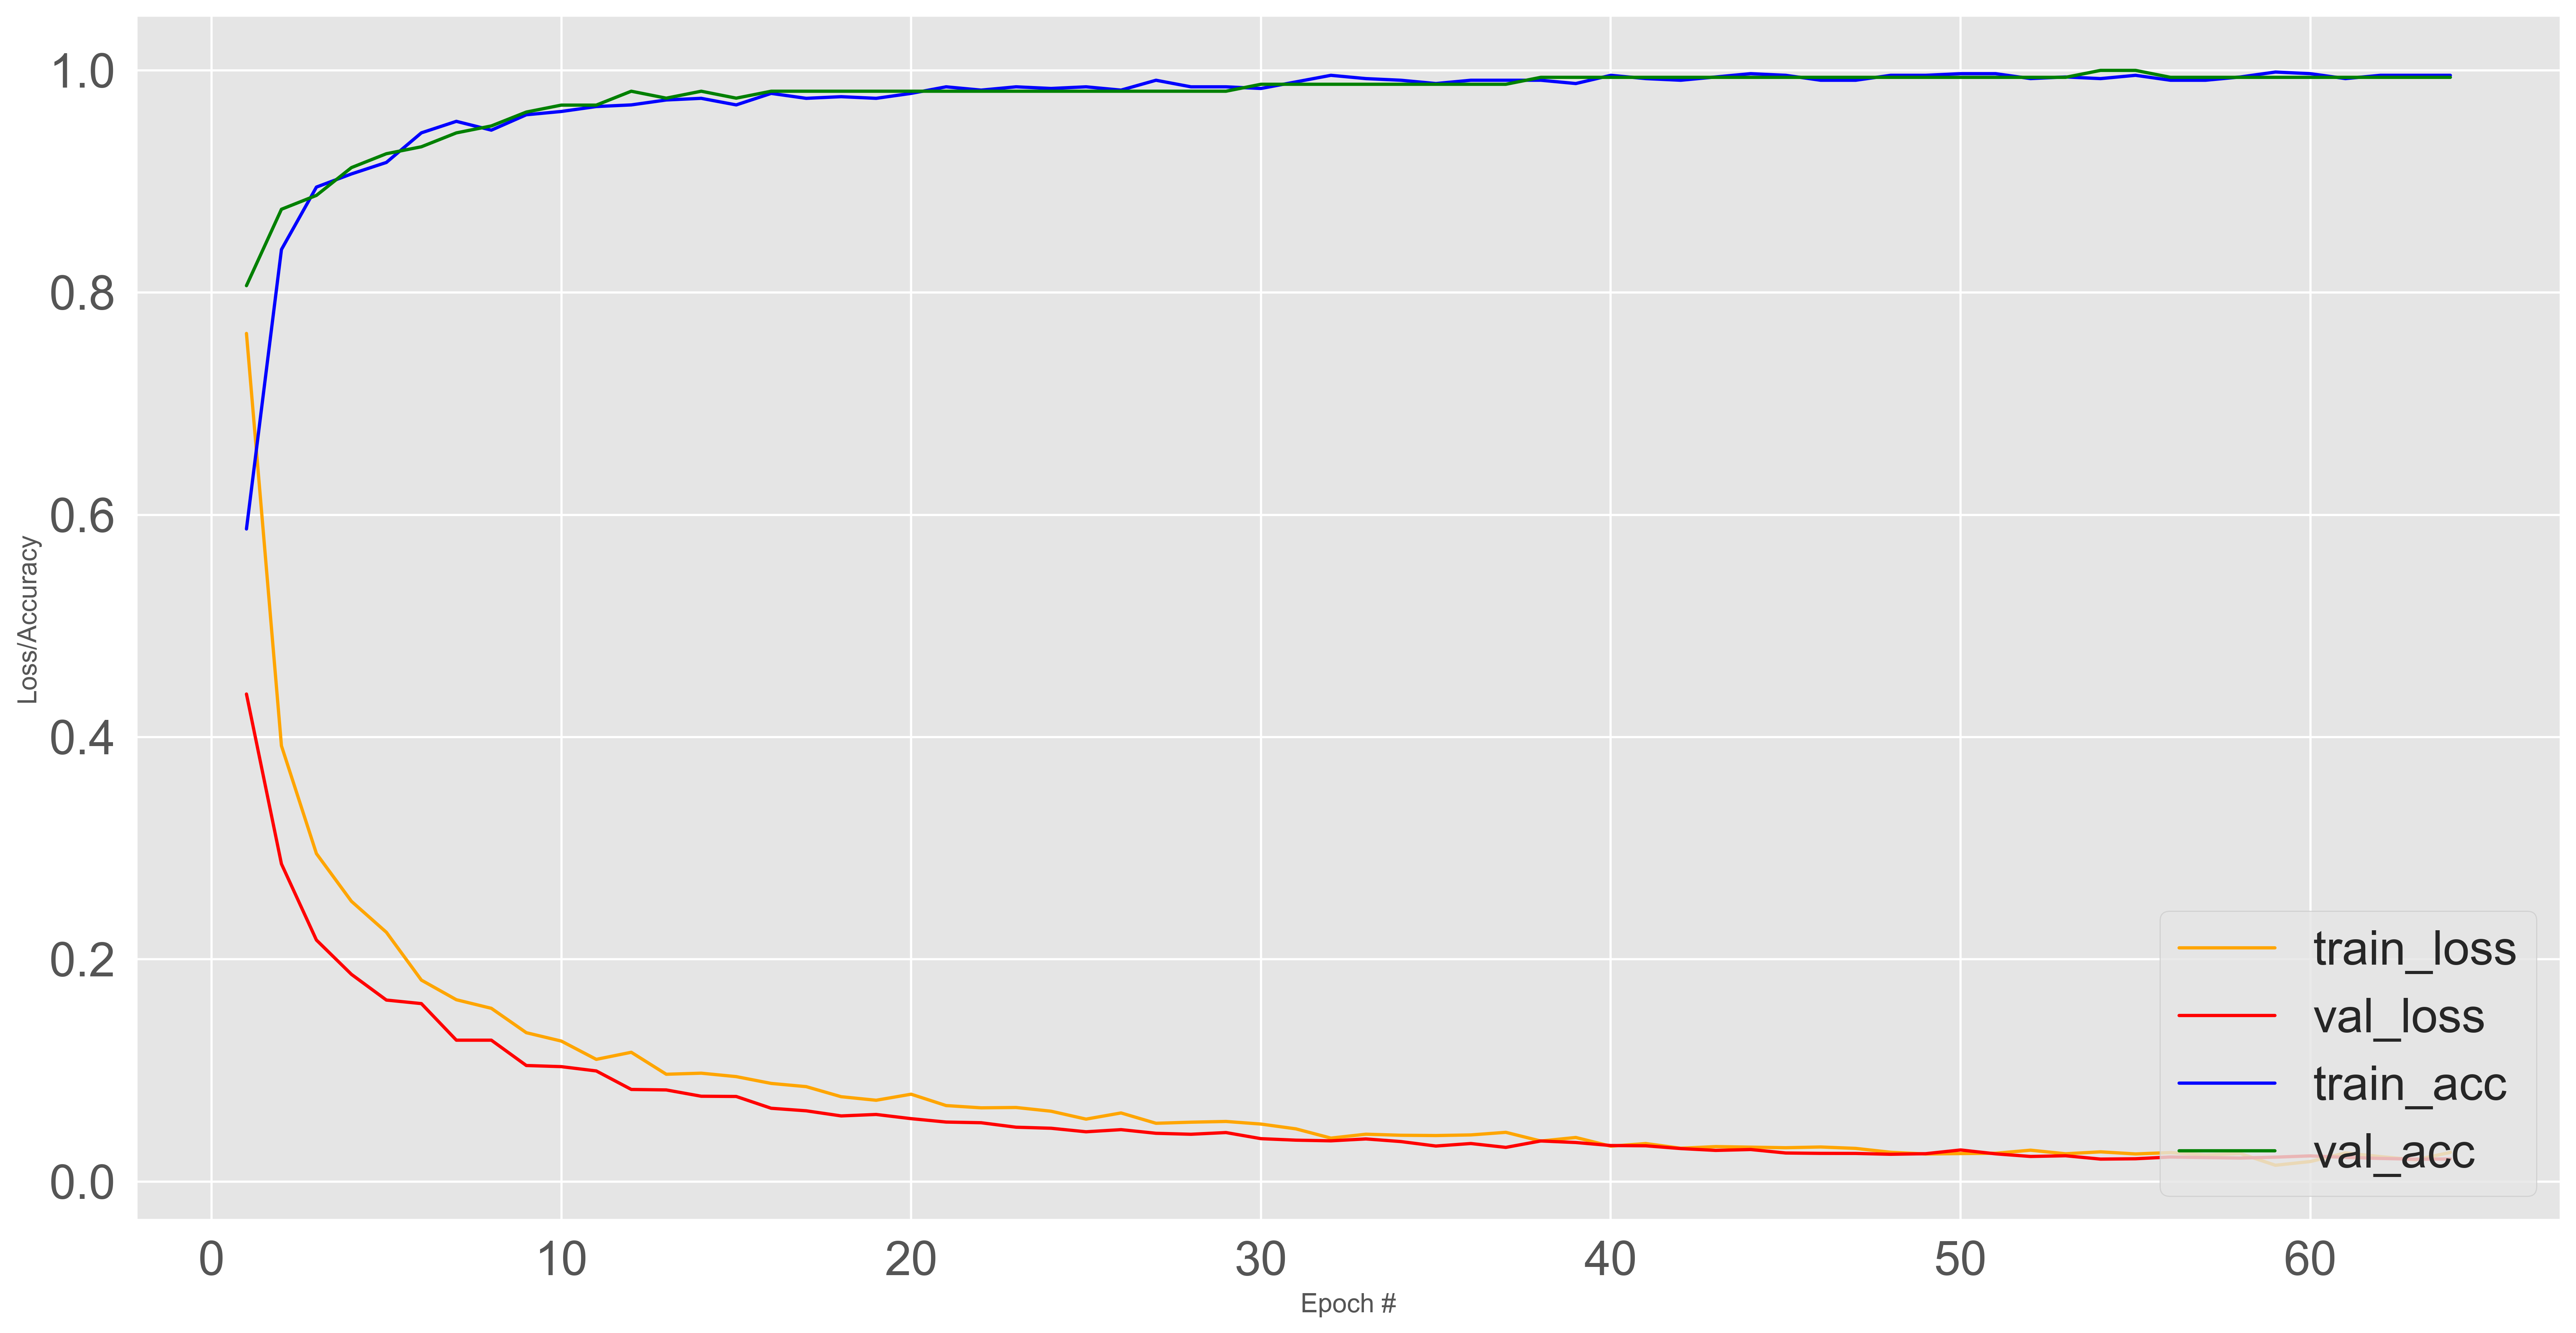

In [64]:
N = 64 #change if early stopping
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=400)
plt.plot(np.arange(1, N+1), 
         model_b16_history.history["loss"], 
         'orange', 
         label="train_loss")
plt.plot(np.arange(1, N+1), 
         model_b16_history.history["val_loss"], 
         'red', 
         label="val_loss")
plt.plot(np.arange(1, N+1), 
          model_b16_history.history["accuracy"], 
          'blue', 
          label="train_acc")
plt.plot(np.arange(1, N+1), 
         model_b16_history.history["val_accuracy"], 
         'green', 
         label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("vit_b16_pretrain_performance.png")

In [24]:
model = load_model('weights/pretraining/vit_b16_finetune_best.h5', compile=False) # path to your stored model
model.summary()

Model: "vit_b16_finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, Non

In [29]:
test_generator.reset() 
custom_y_pred = model.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
custom_y_pred1_label = custom_y_pred.argmax(axis=-1)

6/6 [==============================] - 5s 674ms/step


In [30]:
custom_y_pred1 = custom_y_pred[:,1]

In [31]:
mat_met = matrix_metrix(Y_test1.argmax(axis=-1),
                      custom_y_pred.argmax(axis=-1),
                      beta=0.4)
print (mat_met)

      Metric      Value
0         TP  43.000000
1         TN  48.000000
2         FP   0.000000
3         FN   5.000000
4   Accuracy   0.947900
5  Precision   1.000000
6     Recall   0.895800
7         F1   0.945000
8        MCC   0.900700
9      Kappa   0.895833


In [32]:
target_names = ['No', 'Yes'] 
print(classification_report(Y_test1.argmax(axis=-1),
                            custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

          No     0.9057    1.0000    0.9505        48
         Yes     1.0000    0.8958    0.9451        48

    accuracy                         0.9479        96
   macro avg     0.9528    0.9479    0.9478        96
weighted avg     0.9528    0.9479    0.9478        96



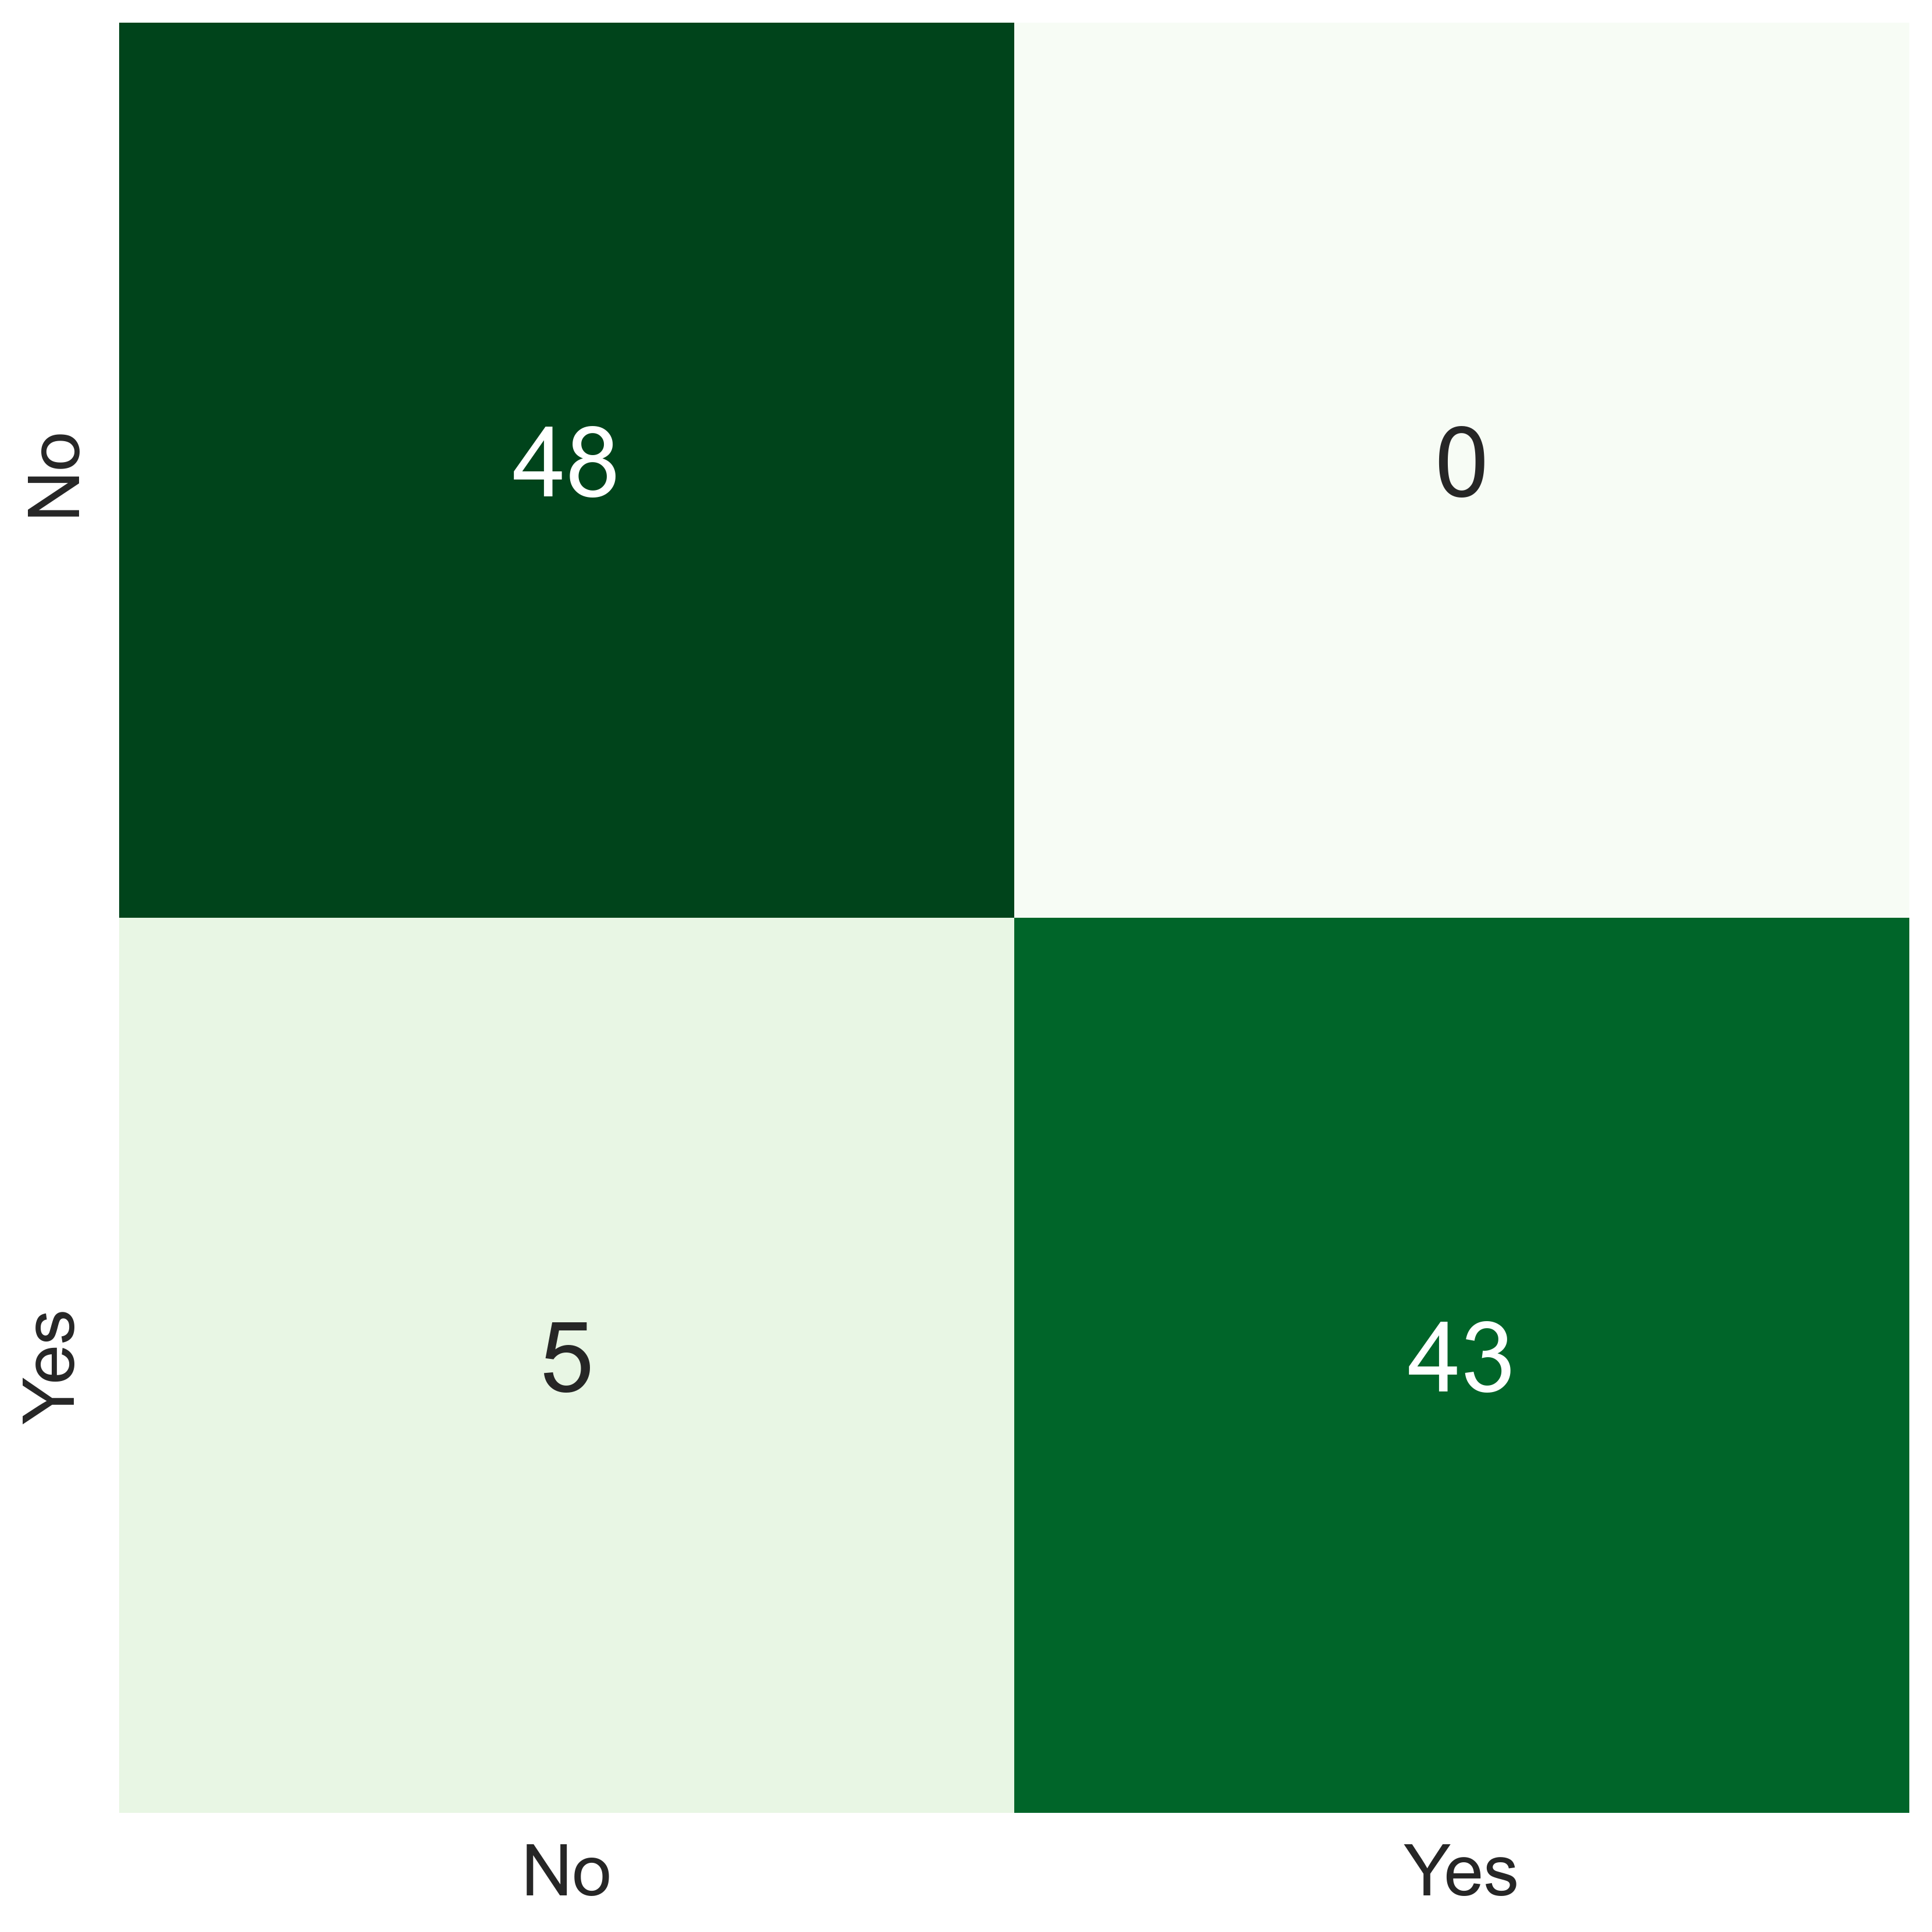

In [33]:
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=5)

x_axis_labels = ['No', 'Yes']  
y_axis_labels = ['No', 'Yes'] 
plt.figure(figsize=(10,10), dpi=400)
sns.set(font_scale=2)
b = sns.heatmap(cnf_matrix, annot=True, square = True, 
            cbar=False, cmap='Greens', 
            annot_kws={'size': 30},
            fmt='g', 
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)

0.9813368055555556


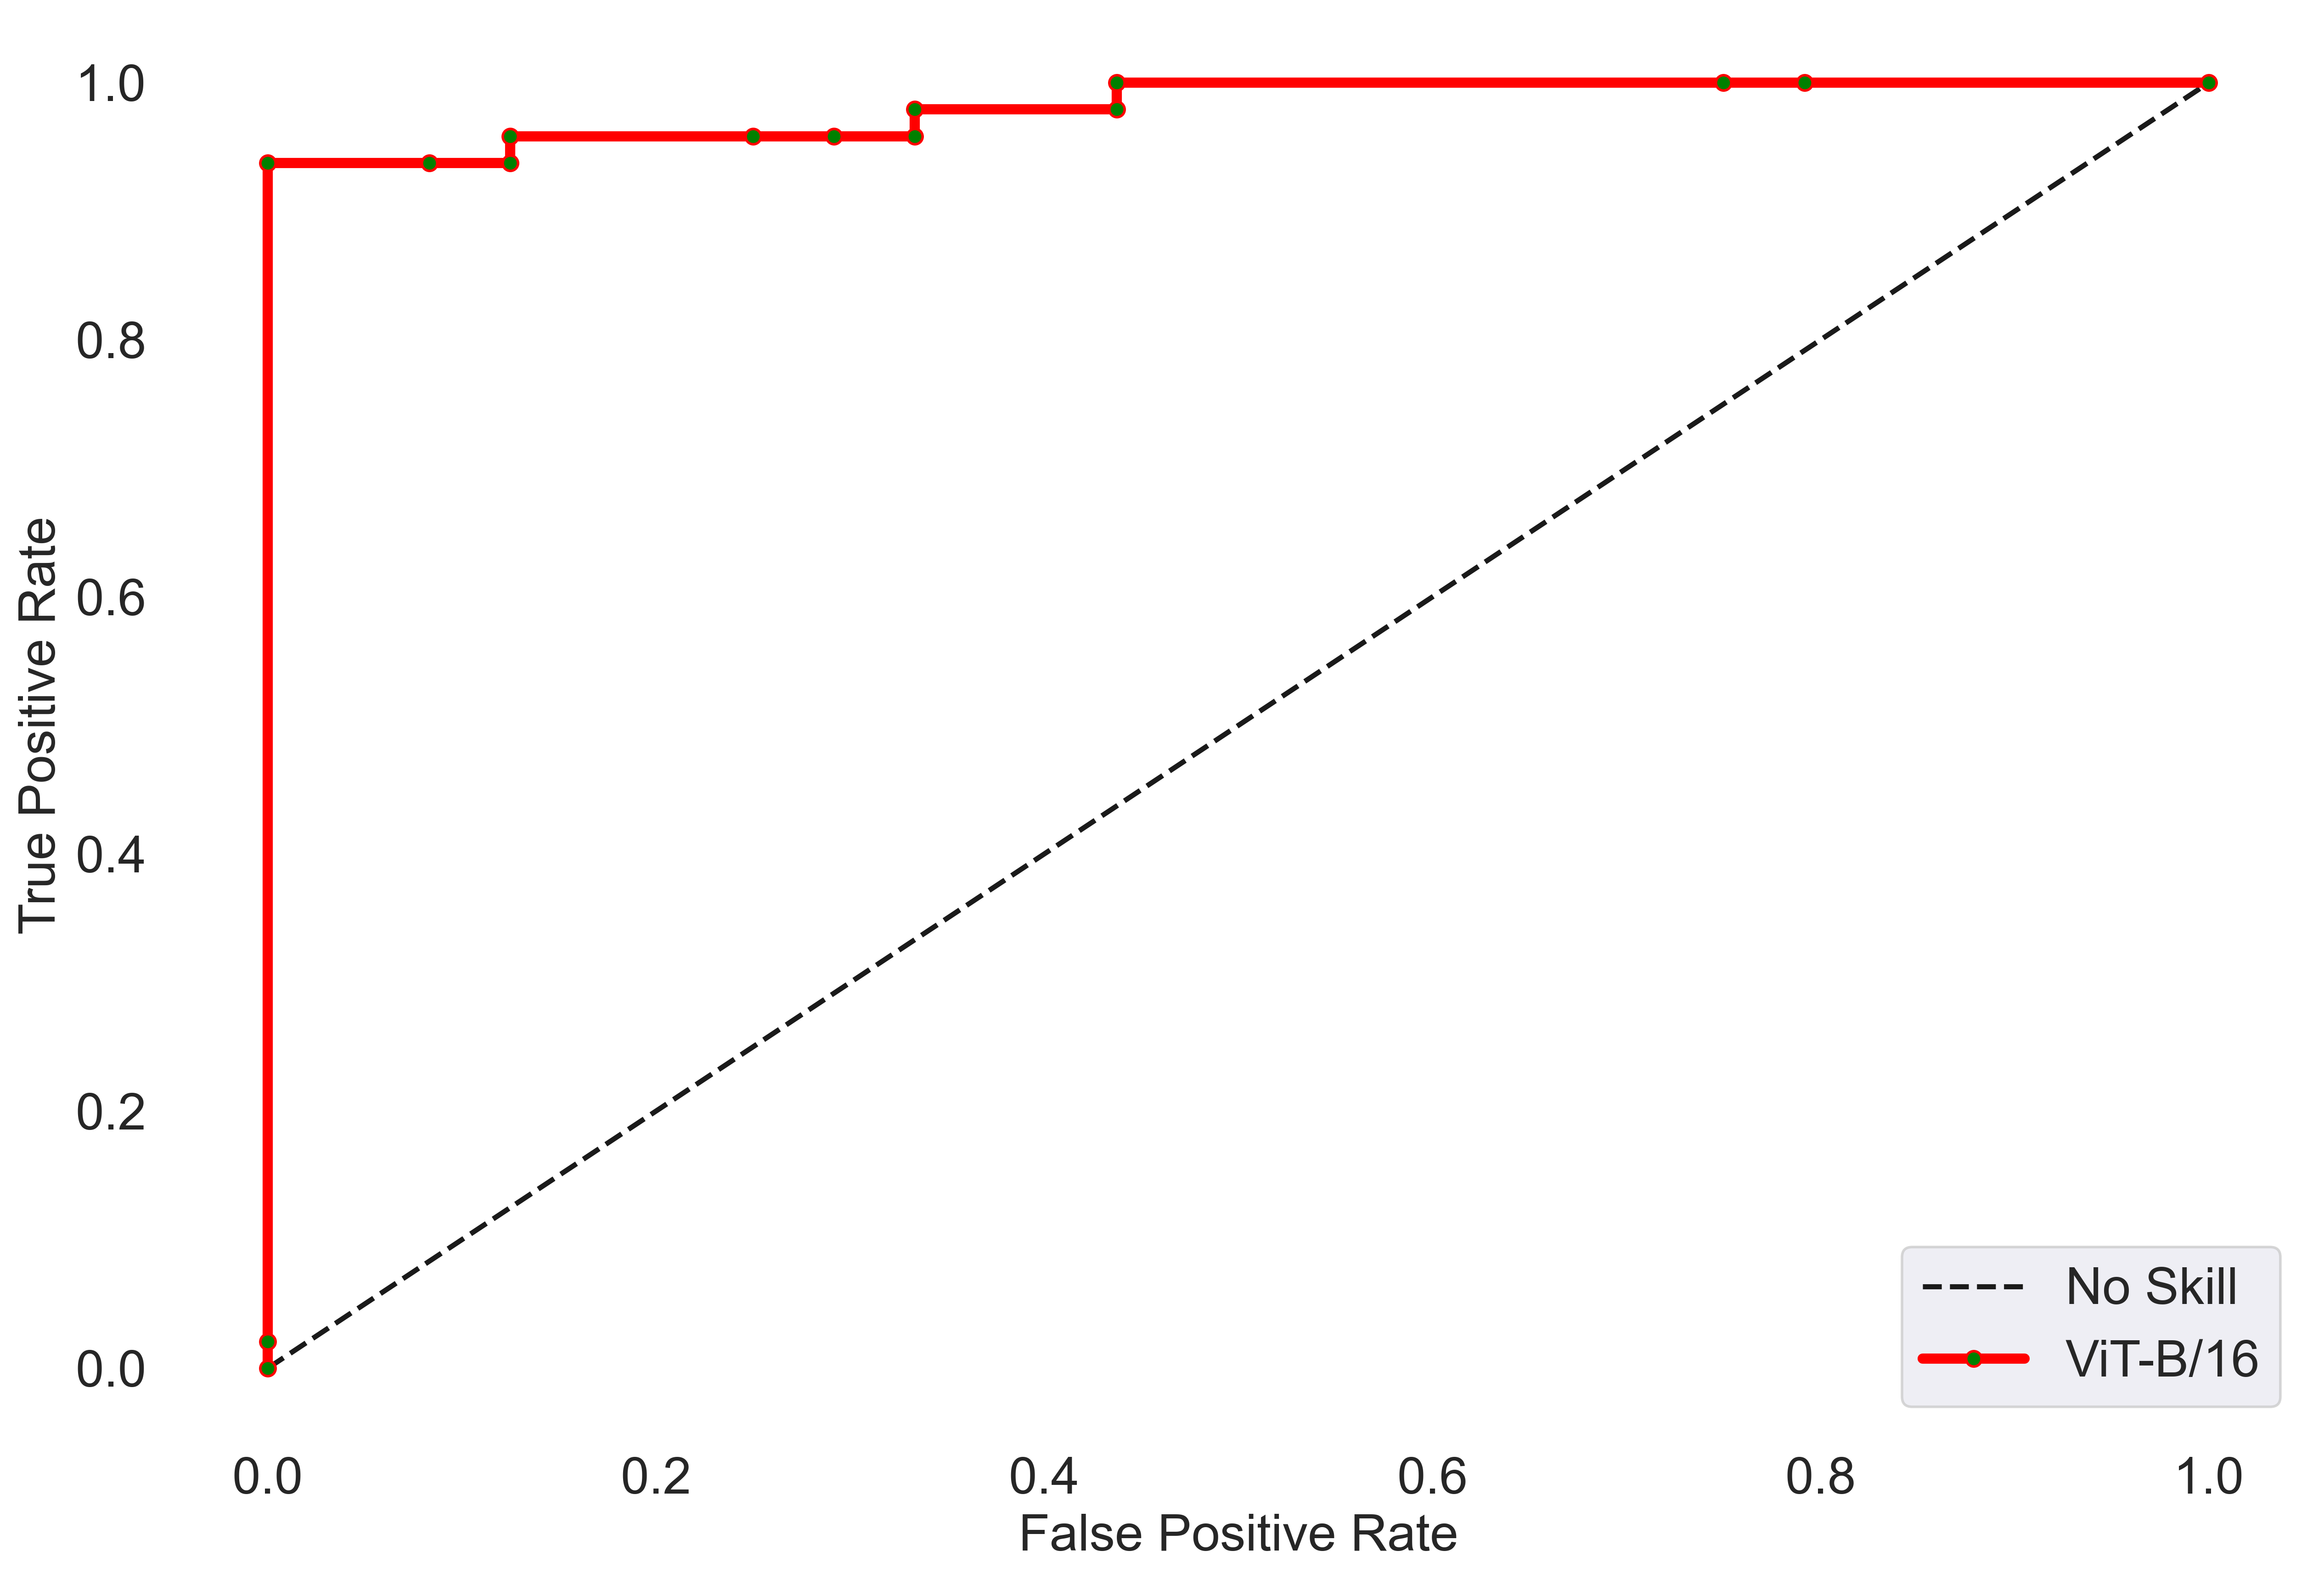

In [34]:
fpr, tpr, thresholds = roc_curve(Y_test, 
                                 custom_y_pred[:,1])
auc_score=roc_auc_score(Y_test, custom_y_pred[:,1])
print(auc_score)
fig=plt.figure(figsize=(15,10), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
major_ticks = np.arange(0.0, 1.1, 0.20) 
minor_ticks = np.arange(0.0, 1.1, 0.20)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
plt.plot([0, 1], [0, 1], 'k--', lw=2, 
         label='No Skill')
plt.plot(fpr, tpr, 
         marker='.',
         markersize=12,
         markerfacecolor='green',
         linewidth=4,
         color='red',
         label='ViT-B/16')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", prop={"size":20})
plt.show()


The average precision value is 0.9859645688450038
The area under the PR curve is 0.9858517104187069


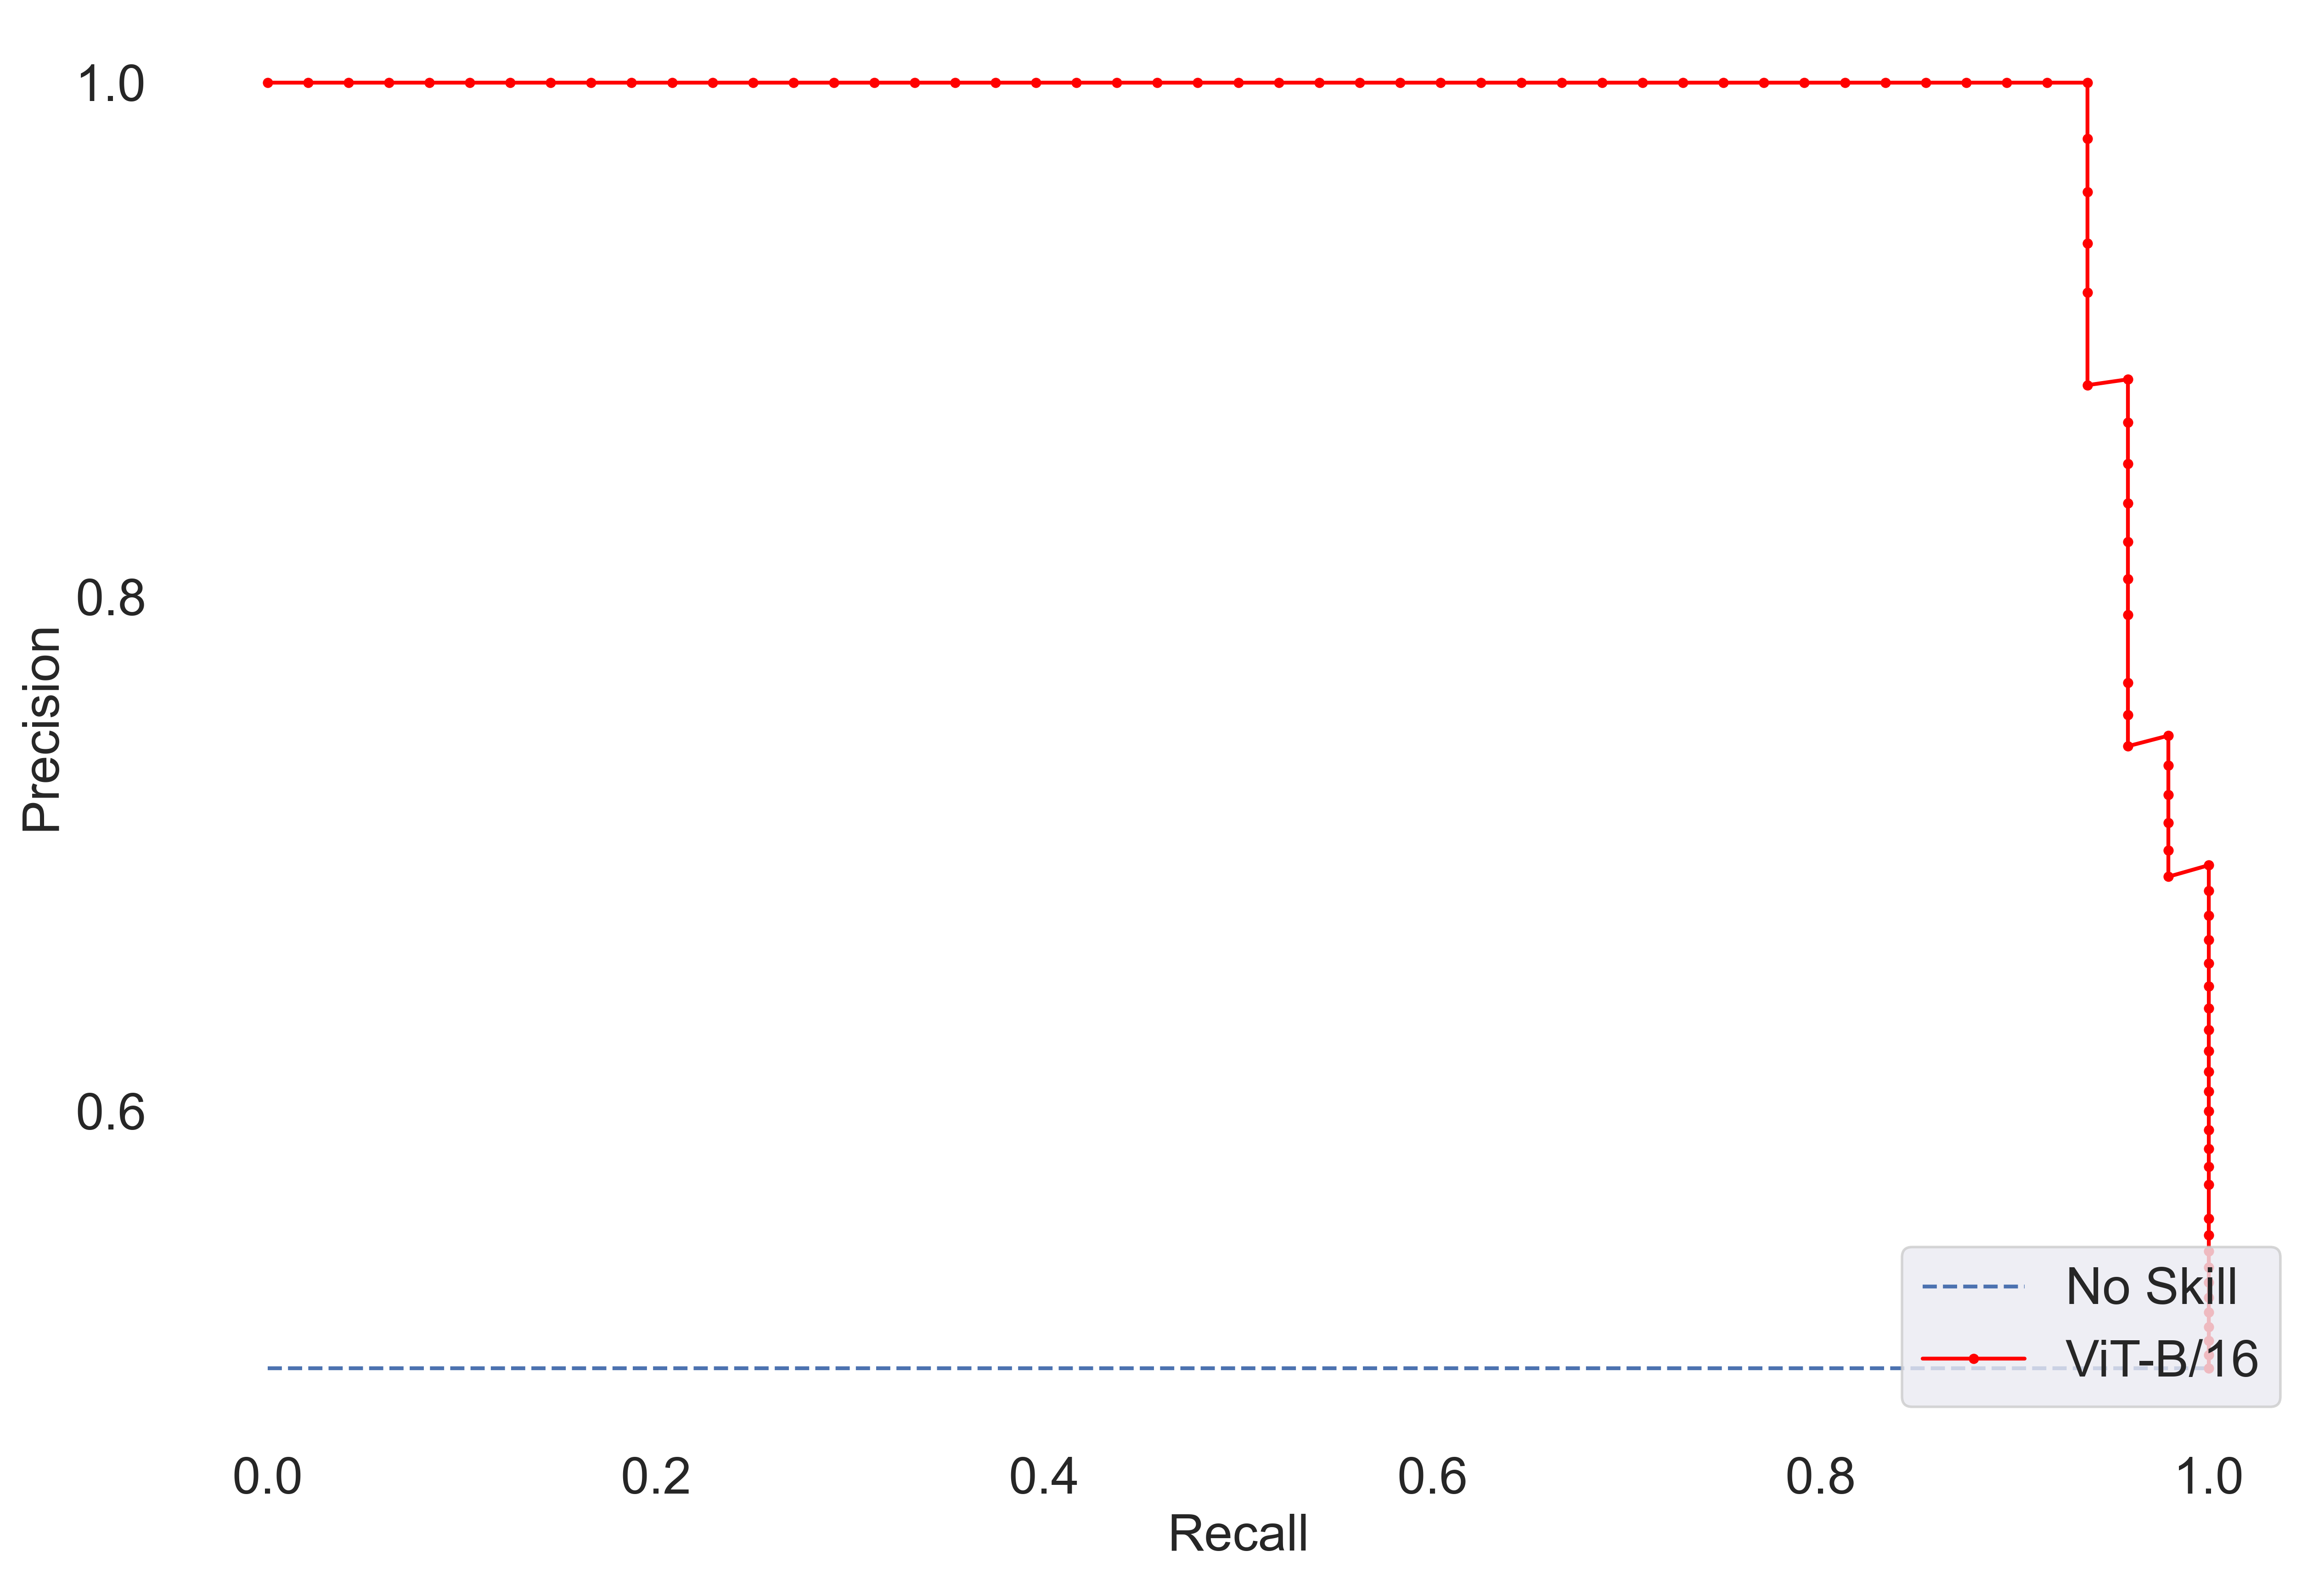

In [35]:
precision, recall, thresholds = precision_recall_curve(Y_test, 
                                 custom_y_pred[:,1])
fscore = (2 * precision * recall) / (precision + recall)

#compute average precision
average_precision_base = average_precision_score(Y_test, 
                                 custom_y_pred[:,1])
print("The average precision value is", average_precision_base)

# area under the PR curve
print("The area under the PR curve is", metrics.auc(recall, precision))

# plot the PR curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
fig=plt.figure(figsize=(15,10), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
major_ticks = np.arange(0.0, 1.1, 0.20) 
minor_ticks = np.arange(0.0, 1.1, 0.20)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
pyplot.plot([0,1], [no_skill,no_skill], 
            linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', 
            color='red', 
            label='ViT-B/16')
# axis labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.legend(loc="lower right", prop={"size":20})
plt.show()

In [28]:
model = VGG16(include_top=False, weights='imagenet', 
                        input_shape=input_shape)
model1 = Model(inputs=model.input, 
                      outputs=model.get_layer('block5_conv3').output)

for layer in model.layers[:-2]:
    layer.trainable = False

x = model1.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, 
                    activation='softmax', 
                    name='predictions')(x)
model_vgg16 = Model(inputs=model1.input, 
                    outputs=predictions, 
                    name='VGG16_pretrain_224')
model_vgg16.summary()

Model: "VGG16_pretrain_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)

In [29]:
for (i,layer) in enumerate(model_vgg16.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D True
18 GlobalAveragePooling2D True
19 Dense True


In [30]:
train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes)
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 1.0, 1: 1.0}


In [32]:
sgd = SGD(learning_rate=0.001, 
          momentum=0.9)  
model_vgg16.compile(optimizer=sgd, 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy']) 

In [33]:
filepath = 'weights/pretraining/' + model_vgg16.name +\
            '.{epoch:02d}-{val_accuracy:.4f}.h5' # path to the stored model
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='min', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=10, 
                              verbose=1, 
                              mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=5,
                              verbose=1,
                              mode='min', 
                              min_lr=0.0001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]
t=time.time()

In [34]:
train_generator.reset()
validation_generator.reset()

#train the model
model_vgg16_history = model_vgg16.fit(train_generator, 
                          steps_per_epoch=nb_train_samples // batch_size,
                          epochs=epochs, 
                          validation_data=validation_generator,
                          callbacks=callbacks_list,
                          class_weight = class_weights,
                          validation_steps=nb_validation_samples // batch_size, 
                          verbose=1)

Epoch 1/64
43/43 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.6213
Epoch 1: val_loss improved from inf to 0.56518, saving model to weights/pretraining/VGG16_pretrain_224.01-0.8938.h5
43/43 [==============================] - 23s 519ms/step - loss: 0.6479 - accuracy: 0.6213 - val_loss: 0.5652 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 2/64


/Users/anilrao/Desktop/Capstone_Code/metal/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.8979
Epoch 2: val_loss improved from 0.56518 to 0.43401, saving model to weights/pretraining/VGG16_pretrain_224.02-0.9062.h5
43/43 [==============================] - 22s 512ms/step - loss: 0.4901 - accuracy: 0.8979 - val_loss: 0.4340 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/64
43/43 [==============================] - ETA: 0s - loss: 0.3812 - accuracy: 0.8935
Epoch 3: val_loss improved from 0.43401 to 0.36065, saving model to weights/pretraining/VGG16_pretrain_224.03-0.9125.h5
43/43 [==============================] - 22s 518ms/step - loss: 0.3812 - accuracy: 0.8935 - val_loss: 0.3607 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 4/64
43/43 [==============================] - ETA: 0s - loss: 0.3131 - accuracy: 0.9053
Epoch 4: val_loss improved from 0.36065 to 0.31358, saving model to weights/pretraining/VGG16_pretrain_224.04-0.8938.h5
43/43 [==============================] - 22s 510ms/step - loss: 0.3131 - accura

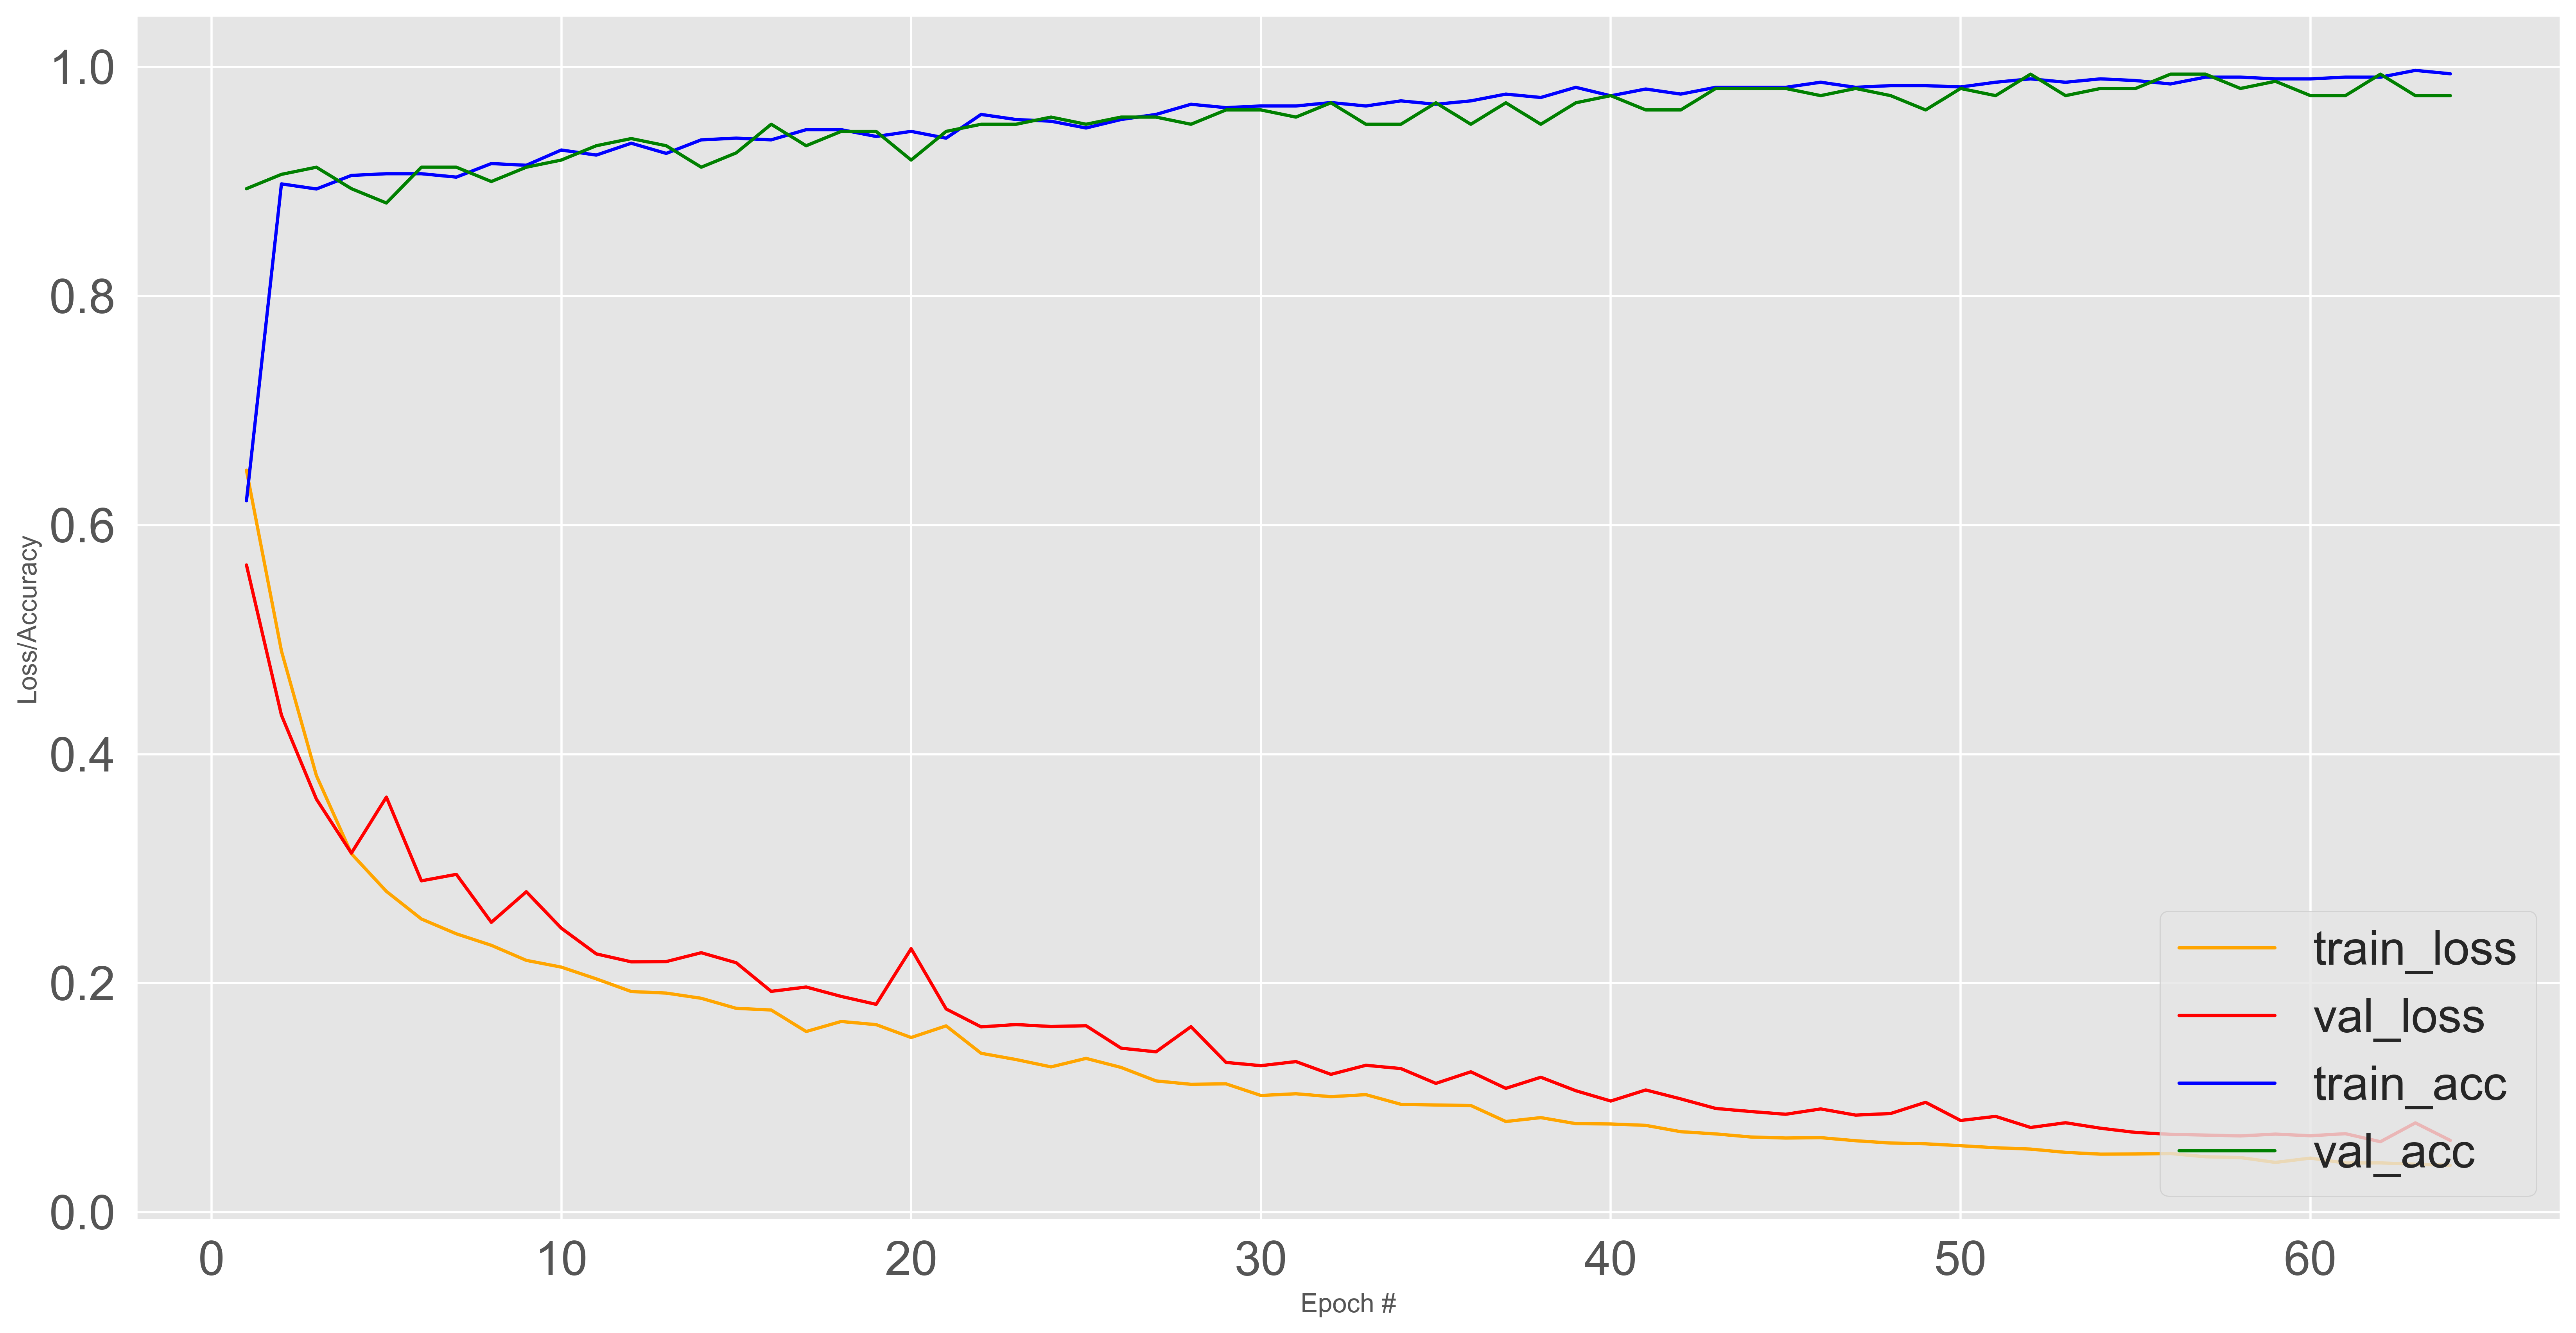

In [36]:
N = 64 #change if early stopping
plt.style.use("ggplot")
plt.figure(figsize=(20,10), dpi=400)
plt.plot(np.arange(1, N+1), 
         model_vgg16_history.history["loss"], 
         'orange', 
         label="train_loss")
plt.plot(np.arange(1, N+1), 
         model_vgg16_history.history["val_loss"], 
         'red', 
         label="val_loss")
plt.plot(np.arange(1, N+1), 
          model_vgg16_history.history["accuracy"], 
          'blue', 
          label="train_acc")
plt.plot(np.arange(1, N+1), 
         model_vgg16_history.history["val_accuracy"], 
         'green', 
         label="val_acc")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower right")
plt.savefig("vit_vgg16_pretrain_performance.png")

In [36]:
model = load_model('weights/pretraining/VGG16_pretrain_224_best.h5', compile=False) # path to your stored model
model.summary()

Model: "VGG16_pretrain_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)

In [37]:
test_generator.reset() 
custom_y_pred = model.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
custom_y_pred1_label = custom_y_pred.argmax(axis=-1)

6/6 [==============================] - 3s 398ms/step


In [38]:
custom_y_pred1 = custom_y_pred[:,1]

In [39]:
mat_met = matrix_metrix(Y_test1.argmax(axis=-1),
                      custom_y_pred.argmax(axis=-1),
                      beta=0.4)
print (mat_met)

      Metric    Value
0         TP  45.0000
1         TN  48.0000
2         FP   0.0000
3         FN   3.0000
4   Accuracy   0.9688
5  Precision   1.0000
6     Recall   0.9375
7         F1   0.9677
8        MCC   0.9393
9      Kappa   0.9375


In [40]:
target_names = ['No', 'Yes'] 
print(classification_report(Y_test1.argmax(axis=-1),
                            custom_y_pred.argmax(axis=-1),
                            target_names=target_names, digits=4))

              precision    recall  f1-score   support

          No     0.9412    1.0000    0.9697        48
         Yes     1.0000    0.9375    0.9677        48

    accuracy                         0.9688        96
   macro avg     0.9706    0.9688    0.9687        96
weighted avg     0.9706    0.9688    0.9687        96



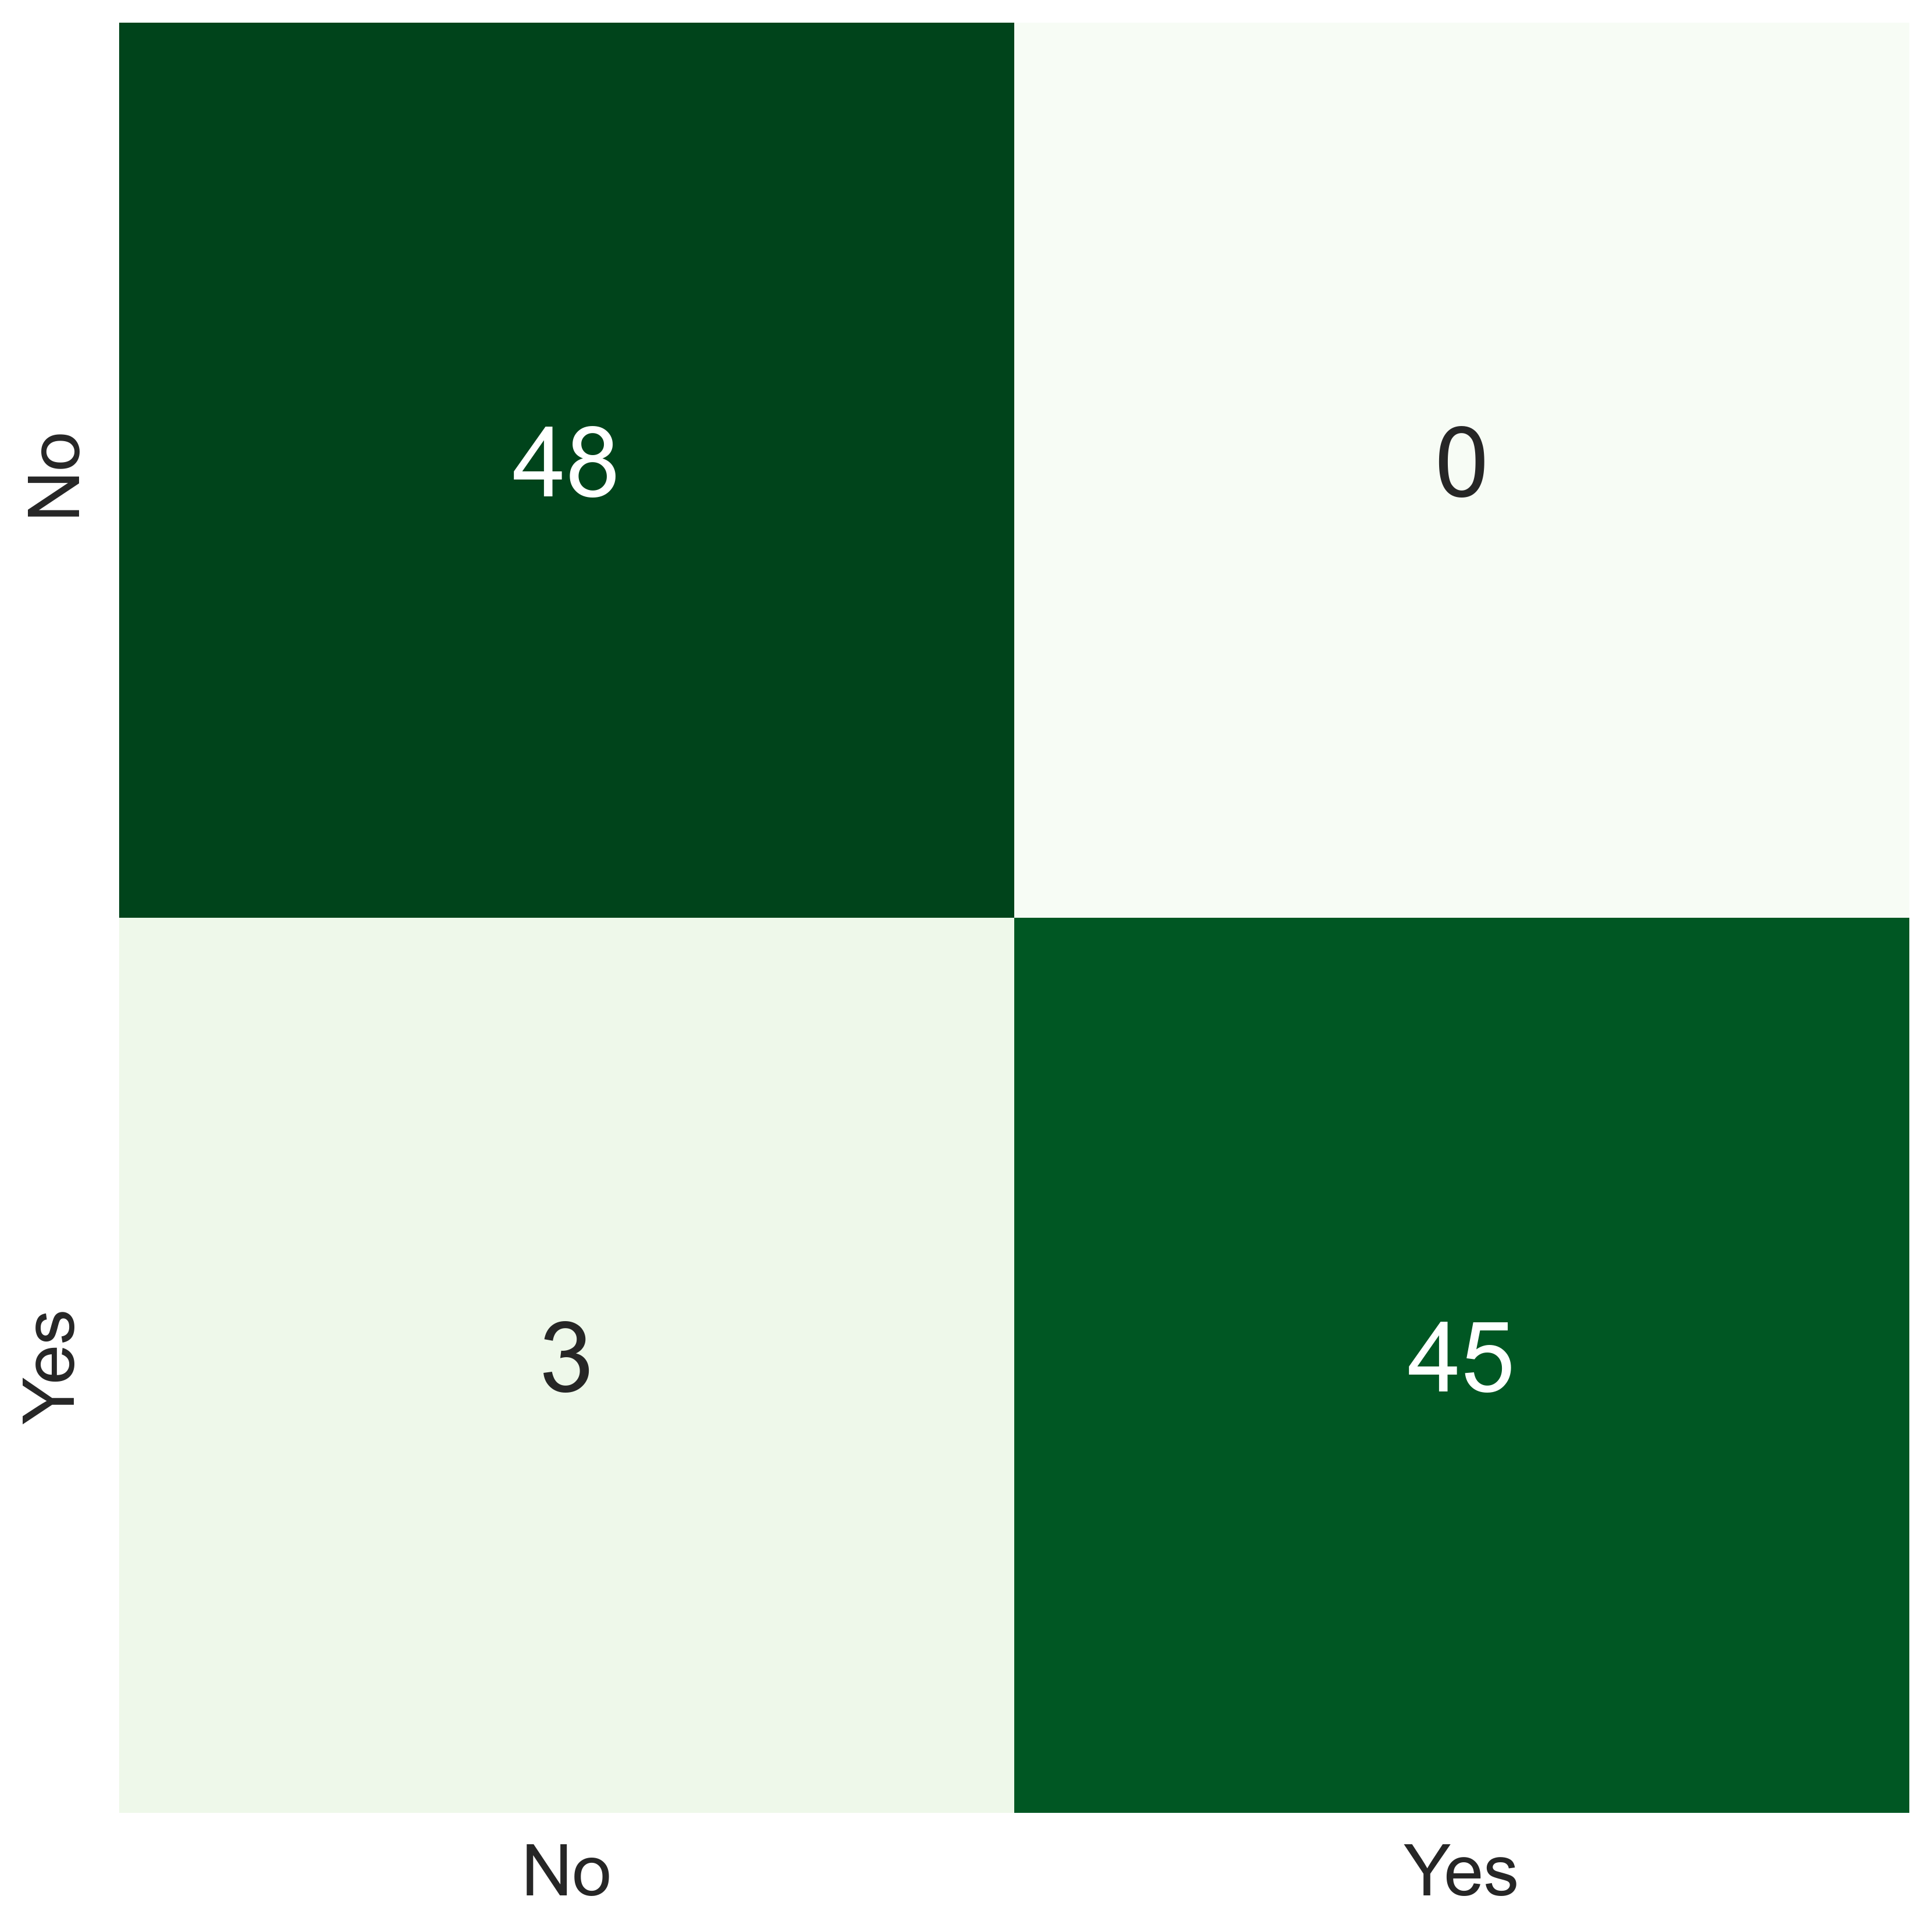

In [41]:
cnf_matrix = confusion_matrix(Y_test1.argmax(axis=-1),
                              custom_y_pred.argmax(axis=-1))
np.set_printoptions(precision=5)

x_axis_labels = ['No', 'Yes']  
y_axis_labels = ['No', 'Yes'] 
plt.figure(figsize=(10,10), dpi=400)
sns.set(font_scale=2)
b = sns.heatmap(cnf_matrix, annot=True, square = True, 
            cbar=False, cmap='Greens', 
            annot_kws={'size': 30},
            fmt='g', 
            xticklabels=x_axis_labels, 
            yticklabels=y_axis_labels)

0.9943576388888888


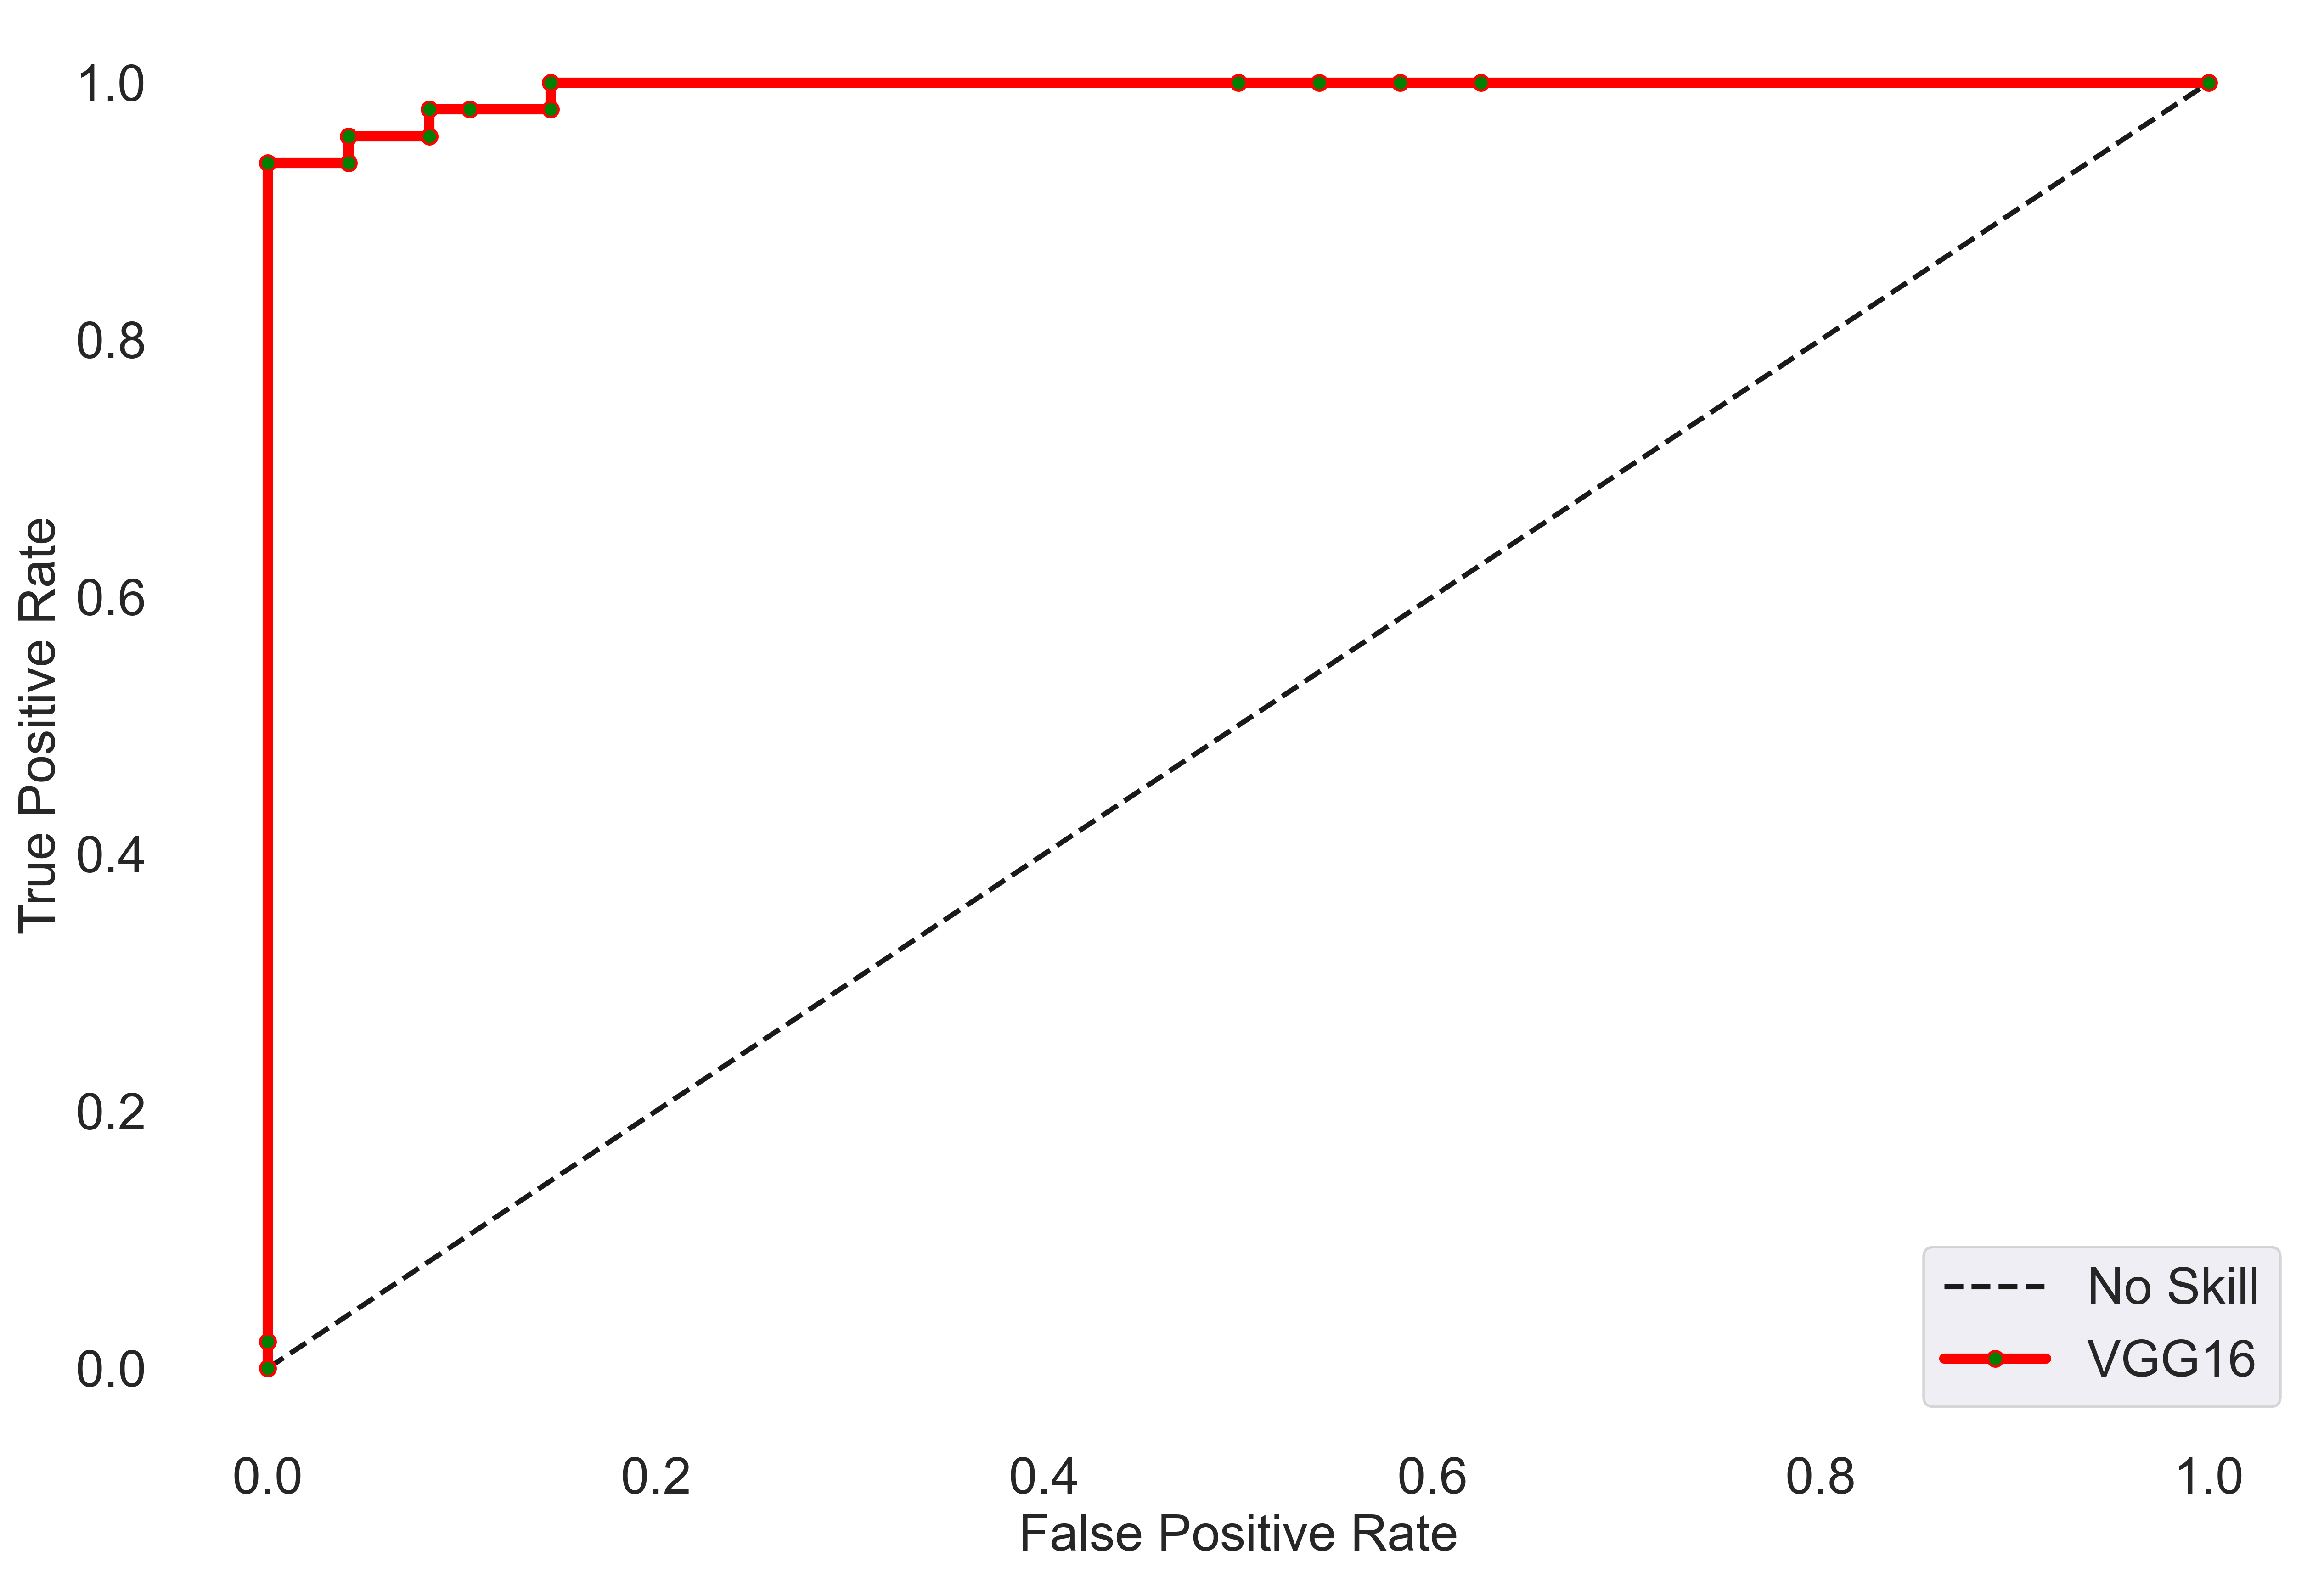

In [42]:
fpr, tpr, thresholds = roc_curve(Y_test, 
                                 custom_y_pred[:,1])
auc_score=roc_auc_score(Y_test, custom_y_pred[:,1])
print(auc_score)
fig=plt.figure(figsize=(15,10), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
major_ticks = np.arange(0.0, 1.1, 0.20) 
minor_ticks = np.arange(0.0, 1.1, 0.20)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
plt.plot([0, 1], [0, 1], 'k--', lw=2, 
         label='No Skill')
plt.plot(fpr, tpr, 
         marker='.',
         markersize=12,
         markerfacecolor='green',
         linewidth=4,
         color='red',
         label='VGG16')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc="lower right", prop={"size":20})
plt.show()

The average precision value is 0.9948464423648249
The area under the PR curve is 0.9947963167957563


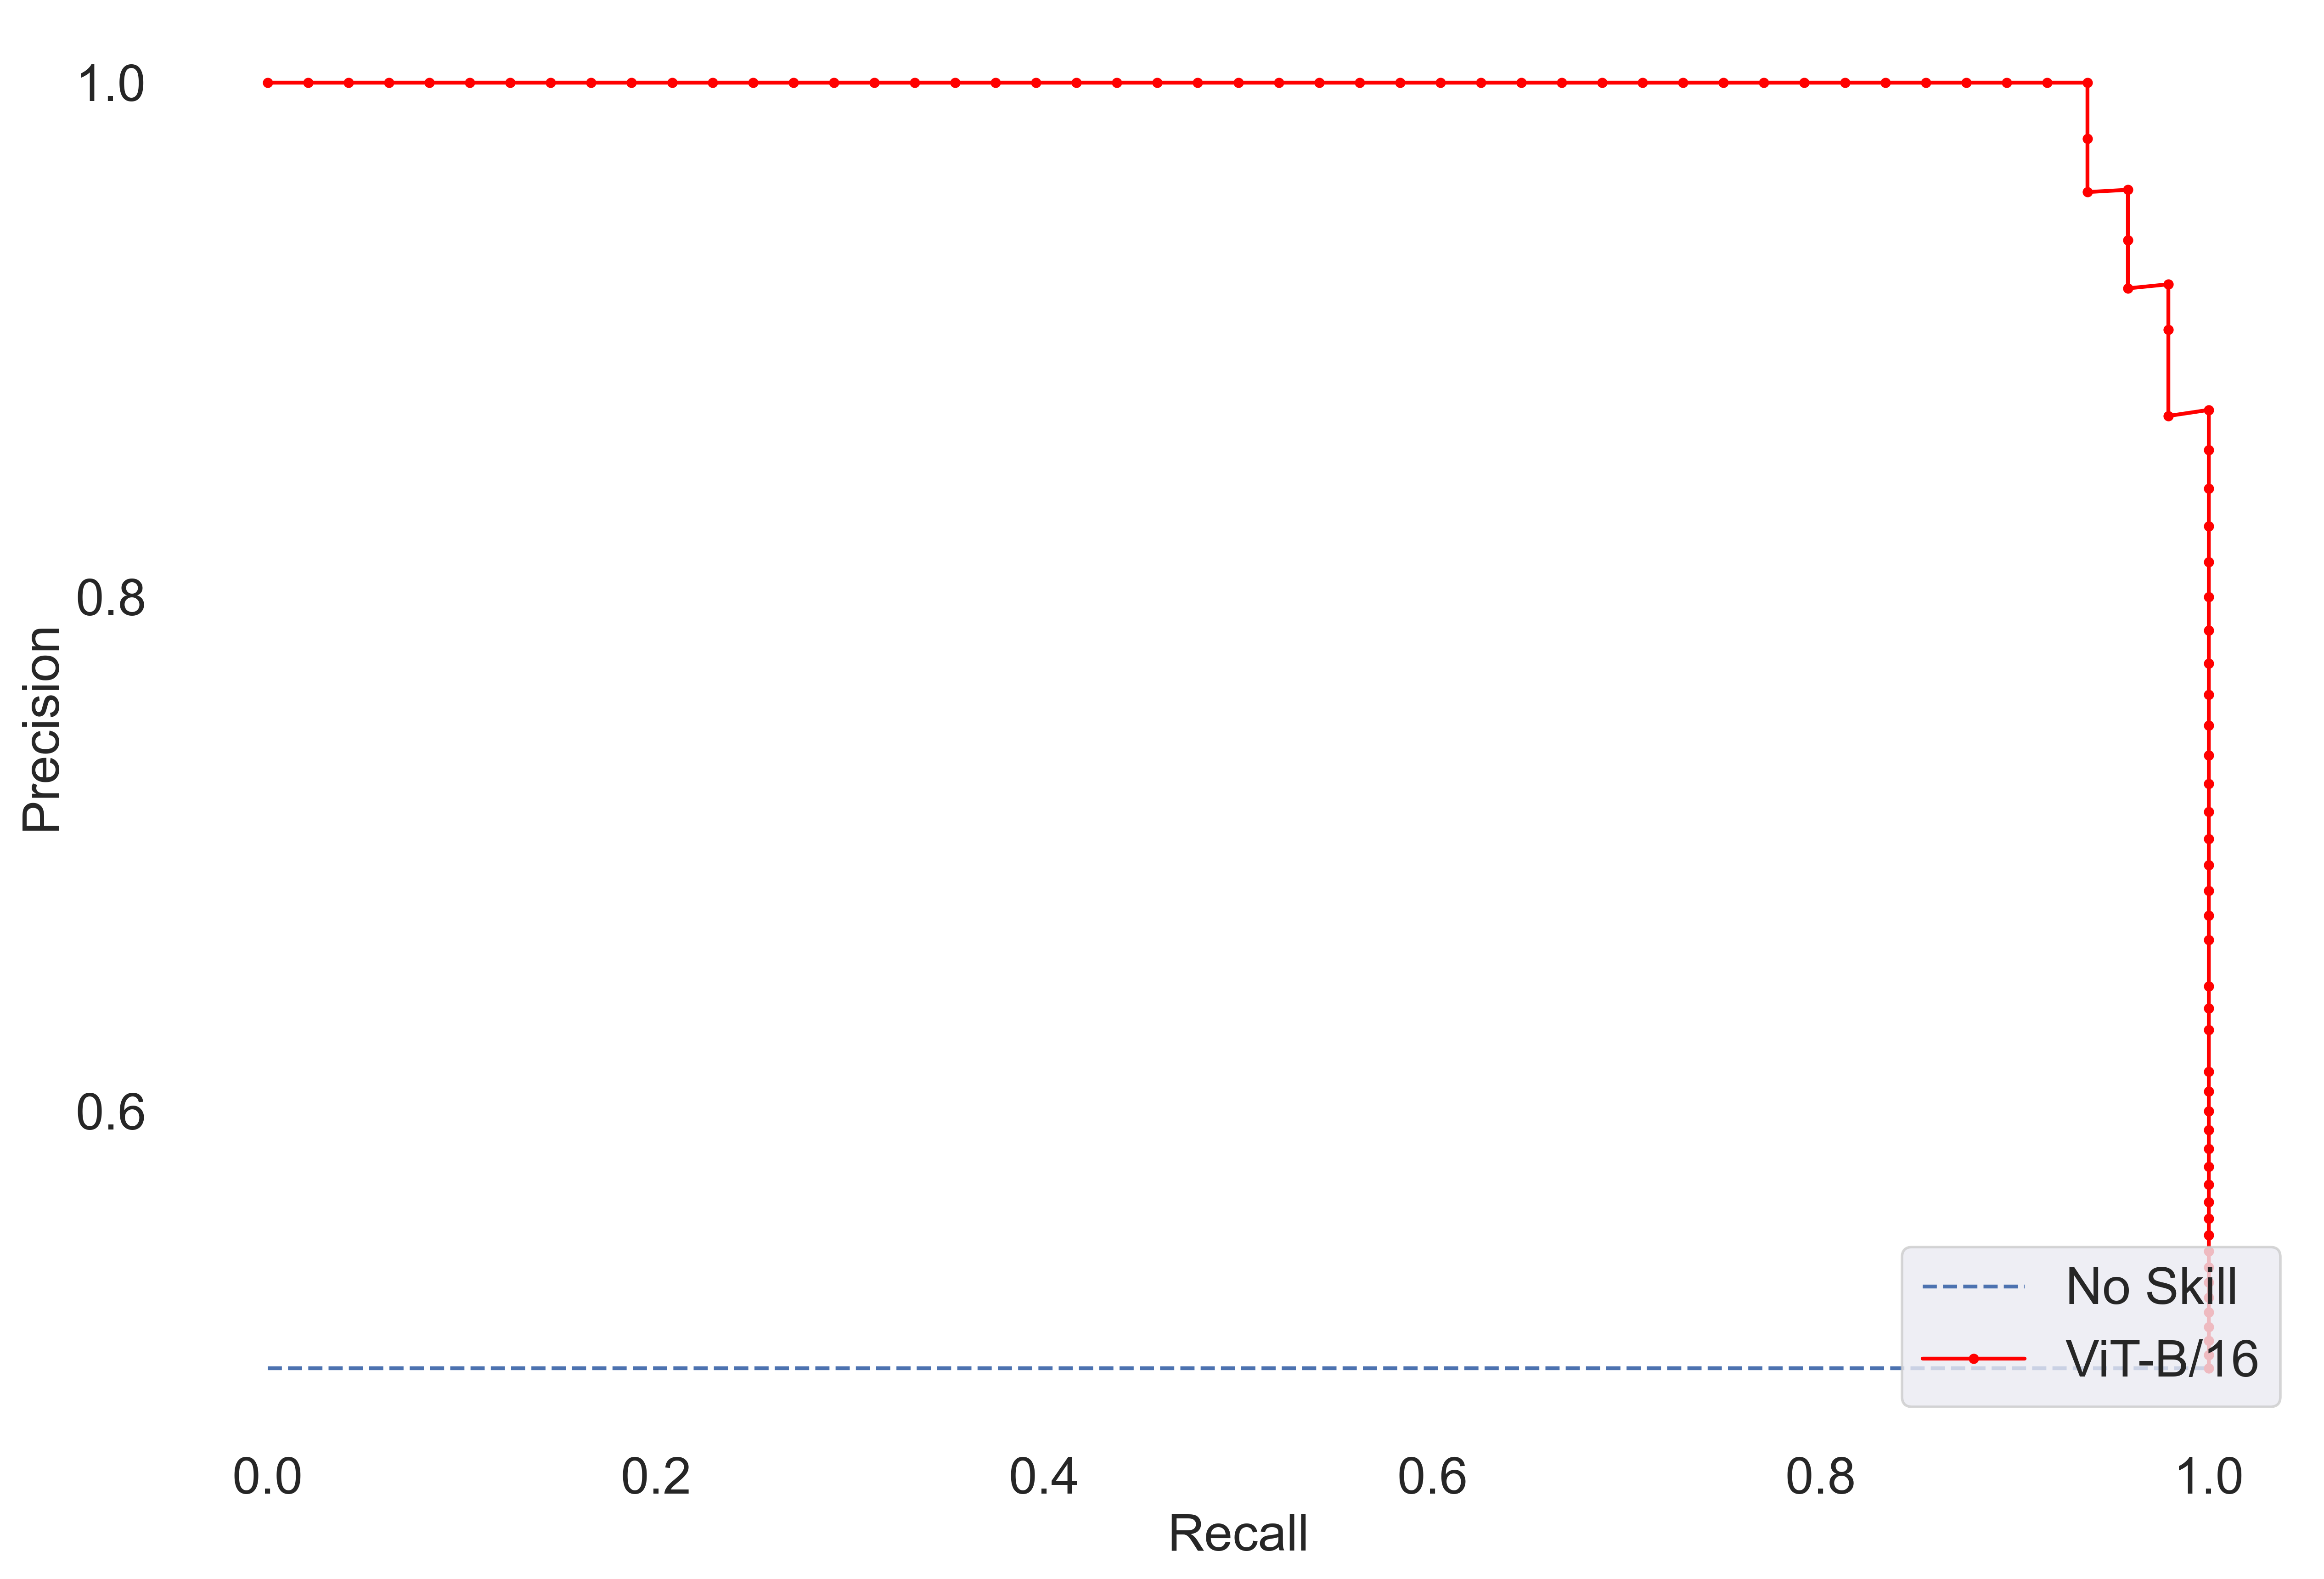

In [43]:
precision, recall, thresholds = precision_recall_curve(Y_test, 
                                 custom_y_pred[:,1])
fscore = (2 * precision * recall) / (precision + recall)

#compute average precision
average_precision_base = average_precision_score(Y_test, 
                                 custom_y_pred[:,1])
print("The average precision value is", average_precision_base)

# area under the PR curve
print("The area under the PR curve is", metrics.auc(recall, precision))

# plot the PR curve for the model
no_skill = len(Y_test[Y_test==1]) / len(Y_test)
fig=plt.figure(figsize=(15,10), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('white')
major_ticks = np.arange(0.0, 1.1, 0.20) 
minor_ticks = np.arange(0.0, 1.1, 0.20)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
pyplot.plot([0,1], [no_skill,no_skill], 
            linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', 
            color='red', 
            label='ViT-B/16')
# axis labels
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.legend(loc="lower right", prop={"size":20})
plt.show()

In [55]:
model1 = load_model('weights/pretraining/vit_b16_finetune_best.h5', #path to the top performing model and so on
                          compile=False)
model1.summary()

#measure performance on test data, 
test_generator.reset()
model1_y_pred = model1.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)



Model: "vit_b16_finetune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 14, 14, 768)       590592    
                                                                 
 reshape_3 (Reshape)         (None, 196, 768)          0         
                                                                 
 class_token (ClassToken)    (None, 197, 768)          768       
                                                                 
 Transformer/posembed_input  (None, 197, 768)          151296    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 197, 768),        7087872   
  (TransformerBlock)          (None, 12, None, Non

In [56]:
#%%
#top-2: 

model2 = load_model('weights/pretraining/VGG16_pretrain_224_best.h5', 
                          compile=False)
model2.summary()

#measure performance on test data, 
test_generator.reset()
model2_y_pred = model2.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)

Model: "VGG16_pretrain_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)

In [57]:
model1_y_pred1 = model1_y_pred
model2_y_pred1 = model2_y_pred


In [58]:
print("The shape of model1 prediction  = ", 
     model1_y_pred1.shape)
print("The shape of model2 prediction  = ", 
     model2_y_pred1.shape)

The shape of model1 prediction  =  (96, 2)
The shape of model2 prediction  =  (96, 2)


In [59]:
model1_y_pred1 = model1_y_pred1.argmax(axis=-1)
model2_y_pred1 = model2_y_pred1.argmax(axis=-1)

In [74]:
preds = [] # repeat for top-3, 5, and 7 models

test_generator.reset()
model1_y_pred = model1.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
preds.append(model1_y_pred)

test_generator.reset()
model2_y_pred = model2.predict(test_generator,
                                    nb_test_samples // batch_size, 
                                    verbose=1)
preds.append(model2_y_pred)

6/6 [==============================] - 2s 381ms/step


In [75]:
def calculate_weighted_accuracy(prediction_weights):
    weighted_predictions = np.zeros((nb_test_samples, num_classes), 
                                    dtype='float32')
    for weight, prediction in zip(prediction_weights, preds):
        weighted_predictions += weight * prediction
    yPred = np.argmax(weighted_predictions, axis=1)
    yTrue = Y_test1.argmax(axis=-1)
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Accuracy : ", accuracy)
    print("Error : ", error)

In [76]:
prediction_weights = [1. / 2] * 2 # change for top-3, 5, and 7 models
print(prediction_weights)
calculate_weighted_accuracy(prediction_weights)

[0.5, 0.5]
Accuracy :  94.79166666666666
Error :  5.208333333333343


In [77]:
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((nb_test_samples, num_classes), 
                                dtype='float32')
    for weight, prediction in zip(weights, preds):
        final_prediction += weight * prediction
    return log_loss(Y_test1, final_prediction)

In [78]:
best_acc = 0.0
best_weights = None

# Parameters for optimization
constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
bounds = [(0, 1)] * len(preds)

In [79]:
NUM_TESTS = 100

for iteration in range(NUM_TESTS):
    
    prediction_weights = np.random.random(2) #change for top-3, 5, and 7 models
    
    # Minimise the loss 
    result = minimize(log_loss_func, 
                      prediction_weights, 
                      method='SLSQP', 
                      bounds=bounds, 
                      constraints=constraints)
    print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
    
    weights = result['x']
    weighted_predictions2 = np.zeros((nb_test_samples, num_classes), 
                                    dtype='float32')  
    
    # Calculate weighted predictions
    for weight, prediction in zip(weights, preds):
        weighted_predictions2 += weight * prediction
    yPred = np.argmax(weighted_predictions2, axis=1)
    yTrue = Y_test1.argmax(axis=-1)
    
    # Calculate weight prediction accuracy
    accuracy = metrics.accuracy_score(yTrue, yPred) * 100
    error = 100 - accuracy
    print("Iteration %d: Accuracy : " % (iteration + 1), accuracy)
    print("Iteration %d: Error : " % (iteration + 1), error)
    
    # Save current best weights 
    if accuracy > best_acc:
        best_acc = accuracy
        best_weights = weights
        
    print()

print("Best Accuracy : ", best_acc)
print("Best Weights : ", best_weights)
calculate_weighted_accuracy(best_weights)


/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/

Best Ensemble Weights: [0.44408 0.55592]
Iteration 1: Accuracy :  94.79166666666666
Iteration 1: Error :  5.208333333333343

Best Ensemble Weights: [0.54269 0.45731]
Iteration 2: Accuracy :  94.79166666666666
Iteration 2: Error :  5.208333333333343

Best Ensemble Weights: [0.39866 0.60134]
Iteration 3: Accuracy :  95.83333333333334
Iteration 3: Error :  4.166666666666657

Best Ensemble Weights: [0.18401 0.81599]
Iteration 4: Accuracy :  96.875
Iteration 4: Error :  3.125

Best Ensemble Weights: [0.16805 0.83195]
Iteration 5: Accuracy :  96.875
Iteration 5: Error :  3.125

Best Ensemble Weights: [0.13491 0.86509]
Iteration 6: Accuracy :  96.875
Iteration 6: Error :  3.125

Best Ensemble Weights: [0.24969 0.75031]
Iteration 7: Accuracy :  96.875
Iteration 7: Error :  3.125

Best Ensemble Weights: [0.44555 0.55445]
Iteration 8: Accuracy :  94.79166666666666
Iteration 8: Error :  5.208333333333343

Best Ensemble Weights: [0.54149 0.45851]
Iteration 9: Accuracy :  94.79166666666666
Iteratio

/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/

Best Ensemble Weights: [0.32952 0.67048]
Iteration 44: Accuracy :  96.875
Iteration 44: Error :  3.125

Best Ensemble Weights: [0.19201 0.80799]
Iteration 45: Accuracy :  96.875
Iteration 45: Error :  3.125

Best Ensemble Weights: [0.59587 0.40413]
Iteration 46: Accuracy :  94.79166666666666
Iteration 46: Error :  5.208333333333343

Best Ensemble Weights: [0.23039 0.76961]
Iteration 47: Accuracy :  96.875
Iteration 47: Error :  3.125

Best Ensemble Weights: [0.5681 0.4319]
Iteration 48: Accuracy :  94.79166666666666
Iteration 48: Error :  5.208333333333343

Best Ensemble Weights: [0.52568 0.47432]
Iteration 49: Accuracy :  94.79166666666666
Iteration 49: Error :  5.208333333333343

Best Ensemble Weights: [0. 1.]
Iteration 50: Accuracy :  96.875
Iteration 50: Error :  3.125

Best Ensemble Weights: [0.55092 0.44908]
Iteration 51: Accuracy :  94.79166666666666
Iteration 51: Error :  5.208333333333343

Best Ensemble Weights: [0.71957 0.28043]
Iteration 52: Accuracy :  94.79166666666666
Ite

/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/

In [82]:
prediction_weights = [0.18401, 0.81599] # weights measured from above
weighted_predictions2 = np.zeros((nb_test_samples, num_classes), 
                                    dtype='float32')
for weight, prediction in zip(prediction_weights, preds):
    weighted_predictions2 += weight * prediction
yPred = np.argmax(weighted_predictions2, axis=1)
yTrue = Y_test1.argmax(axis=-1)
accuracy = metrics.accuracy_score(yTrue, yPred) * 100
error = 100 - accuracy
print("Accuracy : ", accuracy)
print("Error : ", error)

Accuracy :  96.875
Error :  3.125


In [83]:
weighted_predictions21 = weighted_predictions2[:,1]

#%%
#print all metrics

mat_met = matrix_metrix(Y_test1.argmax(axis=-1),
                      weighted_predictions2.argmax(axis=-1),
                      beta=0.4)
print (mat_met)

      Metric    Value
0         TP  45.0000
1         TN  48.0000
2         FP   0.0000
3         FN   3.0000
4   Accuracy   0.9688
5  Precision   1.0000
6     Recall   0.9375
7         F1   0.9677
8        MCC   0.9393
9      Kappa   0.9375


In [86]:
model1 = load_model('weights/pretraining/VGG16_pretrain_224_best.h5', 
                    compile=False)
model1.summary() 
model1 = Model(inputs=model.input, 
                      outputs=model.get_layer('block5_conv3').output)
x1 = model1.output
x1 = Flatten()(x1)
model1v = Model(inputs=model1.input, outputs=x1)

#%%
# model-2:
    
model2 = load_model('weights/pretraining/vit_b16_finetune_best.h5', 
                          compile=False)
model2.summary()

#%%
model2=Model(inputs=model2.input,
                        outputs=model2.get_layer('flatten_3').output)
model2.summary()
x2 = model2.output
model2v = Model(inputs=model2.input, outputs=x2)

Model: "VGG16_pretrain_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)

In [87]:
out1 = model1v(model_input)    
out2 = model2v(model_input)  

In [88]:
mergedOut = Concatenate()([out1,out2]) 
logits = Dense(num_classes, 
               activation='softmax', 
               name='predictions')(mergedOut)                   
model_merge2 = Model(inputs=model_input, 
                    outputs=logits, 
                    name = 'merge_top_2')
model_merge2.summary()

Model: "merge_top_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model_3 (Functional)        (None, 100352)               1471468   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 model_5 (Functional)        (None, 768)                  8579865   ['input_3[0][0]']             
                                                          6                                       
                                                                                        

In [89]:
{i: v for i, v in enumerate(model_merge2.layers)}

# print trainable layers
for l in model_merge2.layers:
    print(l.name, l.trainable)

input_3 True
model_3 True
model_5 True
concatenate True
predictions True


In [90]:
for layer in model_merge2.layers[:5]: #change for the other model ensembles
    layer.trainable = False
for layer in model_merge2.layers[5:]:
    layer.trainable = True

# print trainable layers
for l in model_merge2.layers:
    print(l.name, l.trainable)   

input_3 False
model_3 False
model_5 False
concatenate False
predictions False


In [91]:
sgd = SGD(learning_rate=0.0001, momentum=0.9)  
model_merge2.compile(optimizer=sgd, 
                    loss='categorical_crossentropy',
                    metrics=['accuracy']) 

#%%
#begin training

filepath = 'weights/finetuning/' + \
    model_merge2.name + '.{epoch:02d}-{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, 
                             save_weights_only=False, 
                             save_best_only=True, 
                             mode='max', 
                             save_freq='epoch')
earlyStopping = EarlyStopping(monitor='val_accuracy', 
                              patience=10, 
                              verbose=1, 
                              mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.5, 
                              patience=5,
                              verbose=1,
                              mode='max', 
                              min_lr=0.00001)
callbacks_list = [checkpoint, earlyStopping, reduce_lr]
t=time.time()


In [92]:
train_generator.reset()
test_generator.reset()

#train the model
model_merge2_history = model_merge2.fit(train_generator, 
                                      steps_per_epoch=nb_train_samples // batch_size,
                                      epochs=epochs, 
                                      validation_data=validation_generator,
                                      callbacks=callbacks_list, 
                                      validation_steps=nb_validation_samples // batch_size, 
                                      verbose=1)

print('Training time: %s' % (time.time()-t))

Epoch 1/64
43/43 [==============================] - ETA: 0s - loss: 1.0726 - accuracy: 0.5015
Epoch 1: val_accuracy improved from -inf to 0.53750, saving model to weights/finetuning/merge_top_2.01-0.5375.h5


/Users/anilrao/Desktop/CAPSTONE/Capstone_Code/metal/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


43/43 [==============================] - 66s 1s/step - loss: 1.0726 - accuracy: 0.5015 - val_loss: 1.0377 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 2/64
43/43 [==============================] - ETA: 0s - loss: 1.0735 - accuracy: 0.5015
Epoch 2: val_accuracy did not improve from 0.53750
43/43 [==============================] - 53s 1s/step - loss: 1.0735 - accuracy: 0.5015 - val_loss: 1.0377 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 3/64
43/43 [==============================] - ETA: 0s - loss: 1.0733 - accuracy: 0.5030
Epoch 3: val_accuracy did not improve from 0.53750
43/43 [==============================] - 51s 1s/step - loss: 1.0733 - accuracy: 0.5030 - val_loss: 1.0377 - val_accuracy: 0.5375 - lr: 1.0000e-04
Epoch 4/64
 7/43 [===>..........................] - ETA: 33s - loss: 1.1429 - accuracy: 0.4500

KeyboardInterrupt: 